# **Individual Assignment: YOLOv8 Model Comparison**

This notebook presents a comparative analysis of three different YOLOv8 models: YOLOv8n (Nano), YOLOv8s (Small), and YOLOv8m (Medium). The goal is to evaluate each model's performance in terms of accuracy, speed, and resource efficiency. We will go through environment setup, dataset preparation, model training, results visualization, and finally, model evaluation and prediction.

*Author: Joaquin Moscoso Vega*

## **1. Environment Setup**

Before we start, it's crucial to set up our working environment. This involves checking GPU availability, installing necessary dependencies, and ensuring our setup is optimized for training and evaluating deep learning models.


In [1]:
# The `nvidia-smi` (NVIDIA System Management Interface) command provides information about NVIDIA GPU devices.
# It displays the GPU model, utilization, GPU memory usage, and temperature among other details.
# This command is useful for monitoring the GPU status and ensuring it is recognized by the system and available for deep learning tasks.

!nvidia-smi

Wed Feb  7 11:34:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install a specific version of the Ultralytics package, which is a collection of utilities and tools for working with YOLO models.
!pip install ultralytics==8.0.196

# After installing packages in a Jupyter notebook, it's often useful to clear the output to keep the notebook tidy.
from IPython import display
display.clear_output()

# Now, we import the ultralytics package to use its functionalities, such as model training, evaluation, and inference.
import ultralytics

# It's a good practice to perform checks after importing a library, especially a complex one like ultralytics.
# These checks can ensure that the library is installed correctly and its dependencies are properly configured.
ultralytics.checks()


Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [3]:
# This command is used to install and update the Ultralytics and Ray Tune packages.
# Ultralytics is widely used for working with YOLO (You Only Look Once) models for object detection tasks.
# Ray Tune is a Python library for experiment execution and hyperparameter tuning at scale.
!pip install -U ultralytics "ray[tune]"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.4/709.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.0.196
    Uninstalling ultralytics-8.0.196:
      Successfully uninstalled ultralytics-8.0.196


In [1]:
# Importing specific functionalities from the ultralytics and IPython.display libraries.
from ultralytics import YOLO  # Import the YOLO class from the ultralytics library. This class is typically used for loading YOLO models, making predictions, and processing images.

# The IPython.display library is used for displaying objects in Jupyter notebooks in a more interactive and visually appealing way.
from IPython.display import display, Image

## **2. Dataset Preparation**

The quality of our dataset directly impacts the model's performance. In this section, we'll mount our Google Drive to access the dataset, set up dataset paths, and update dataset configurations to align with our training requirements.



In [2]:
# Import the `drive` module from the `google.colab` library to enable Google Drive integration with Google Colab notebooks.
from google.colab import drive

# Mount Google Drive to the Colab environment, allowing access to its files directly from the notebook.
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Define the base path to the dataset stored in Google Drive.
dataset_path = '/content/drive/MyDrive/assigment'

# Specify the paths to the training and validation subsets within the dataset.
train_path = dataset_path + '/train'  # Path to the training data.
val_path = dataset_path + '/val'      # Path to the validation data.

# Define the path to the dataset configuration file (YAML format).
data_yaml_path = dataset_path + '/dataset.yaml'  # Configuration file containing dataset details.


In [4]:
# Import the `yaml` module to enable YAML file parsing and generation, useful for handling configuration files.
import yaml

In [5]:
# Open the YAML configuration file for reading to load its current contents.
# `data_yaml_path` specifies the file path.
with open(data_yaml_path, 'r') as file:
    data_yaml = yaml.safe_load(file)  # Use `safe_load` to parse the YAML content safely into a Python dictionary.

# Update the 'train' and 'val' paths in the loaded dictionary with the new paths.
data_yaml['train'] = train_path  # Update the training data path.
data_yaml['val'] = val_path  # Update the validation data path.

# Open the YAML configuration file again, this time for writing, to save the updated content.
with open(data_yaml_path, 'w') as file:
    yaml.dump(data_yaml, file)  # Use `dump` to serialize the updated dictionary back into YAML format and write it to the file.


In [6]:
#check directory content python
%pwd

'/content'

## **3. Model Training**

We will train three different YOLOv8 models with our dataset. Each model variant (Nano, Small, and Medium) is designed for different use cases, balancing speed and accuracy. We begin with a general overview of the training process, applicable to all models.


### Training Parameters Explained
<table>
<tr>
<td valign="top">

- `task=detect`: Sets the task to object detection.

- `mode=train`: Configures the operation mode to training.
- `model=yolov8n.pt`: Utilizes the YOLOv8n model, optimized for speed and efficiency.
- `data={dataset_path}/dataset.yaml`: Points to the dataset configuration file.
- `epochs=25`: Trains the model for 25 epochs.
- `batch=16`: Sets the batch size to 16.
- `imgsz=800`: Defines the input image size as 800x800 pixels.
- `save=True`: Enables saving of the model weights.

</td>
<td valign="top">

- `cache=True`: Activates image caching for faster loading.

- `device=cuda:0`: Specifies training on the first GPU.
- `workers=8`: Allocates 8 worker threads for data loading.
- `single_cls=True`: Indicates the dataset contains only a single class.
- `amp=True`: Enables Automatic Mixed Precision.
- `val=True`: Runs validation after each epoch.
- `plots=True`: Generates various plots to visualize training progress.

</td>
</tr>
</table>


### 3.1 YOLOv8n (Nano) Model

The YOLOv8n model is optimized for environments with limited computational resources, prioritizing speed and efficiency. Let's dive into the training specifics for the Nano model, expecting it to be the fastest among the three, albeit potentially at the cost of some accuracy.



In [7]:
# Run YOLO training task
!yolo task=detect mode=train model=yolov8n.pt data={dataset_path}/dataset.yaml epochs=25 batch=16 imgsz=800 save=True cache=True device=cuda:0 workers=8 single_cls=True amp=True val=True plots=True

100% 6.23M/6.23M [00:00<00:00, 83.8MB/s]
Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/assigment/dataset.yaml, epochs=25, time=None, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=True, device=cuda:0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fals

In [8]:
# This command lists all files and directories in the current working directory of the Jupyter notebook.
# It's useful for verifying the contents of a directory, ensuring that expected files or directories are present.
!ls

drive  runs  yolov8n.pt


In [9]:
# This command lists the files and directories located in '/content/runs/detect/train'.
# It's typically used to check the results of a training process, like model checkpoints, logs, and output images or plots.
!ls /content/runs/detect/train


args.yaml					    R_curve.png        val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv        val_batch0_pred.jpg
confusion_matrix.png				    results.png        val_batch1_labels.jpg
events.out.tfevents.1707305924.36876801e9a7.1535.0  train_batch0.jpg   val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch2.jpg   val_batch2_pred.jpg
labels.jpg					    train_batch75.jpg  weights
P_curve.png					    train_batch76.jpg
PR_curve.png					    train_batch77.jpg


/content


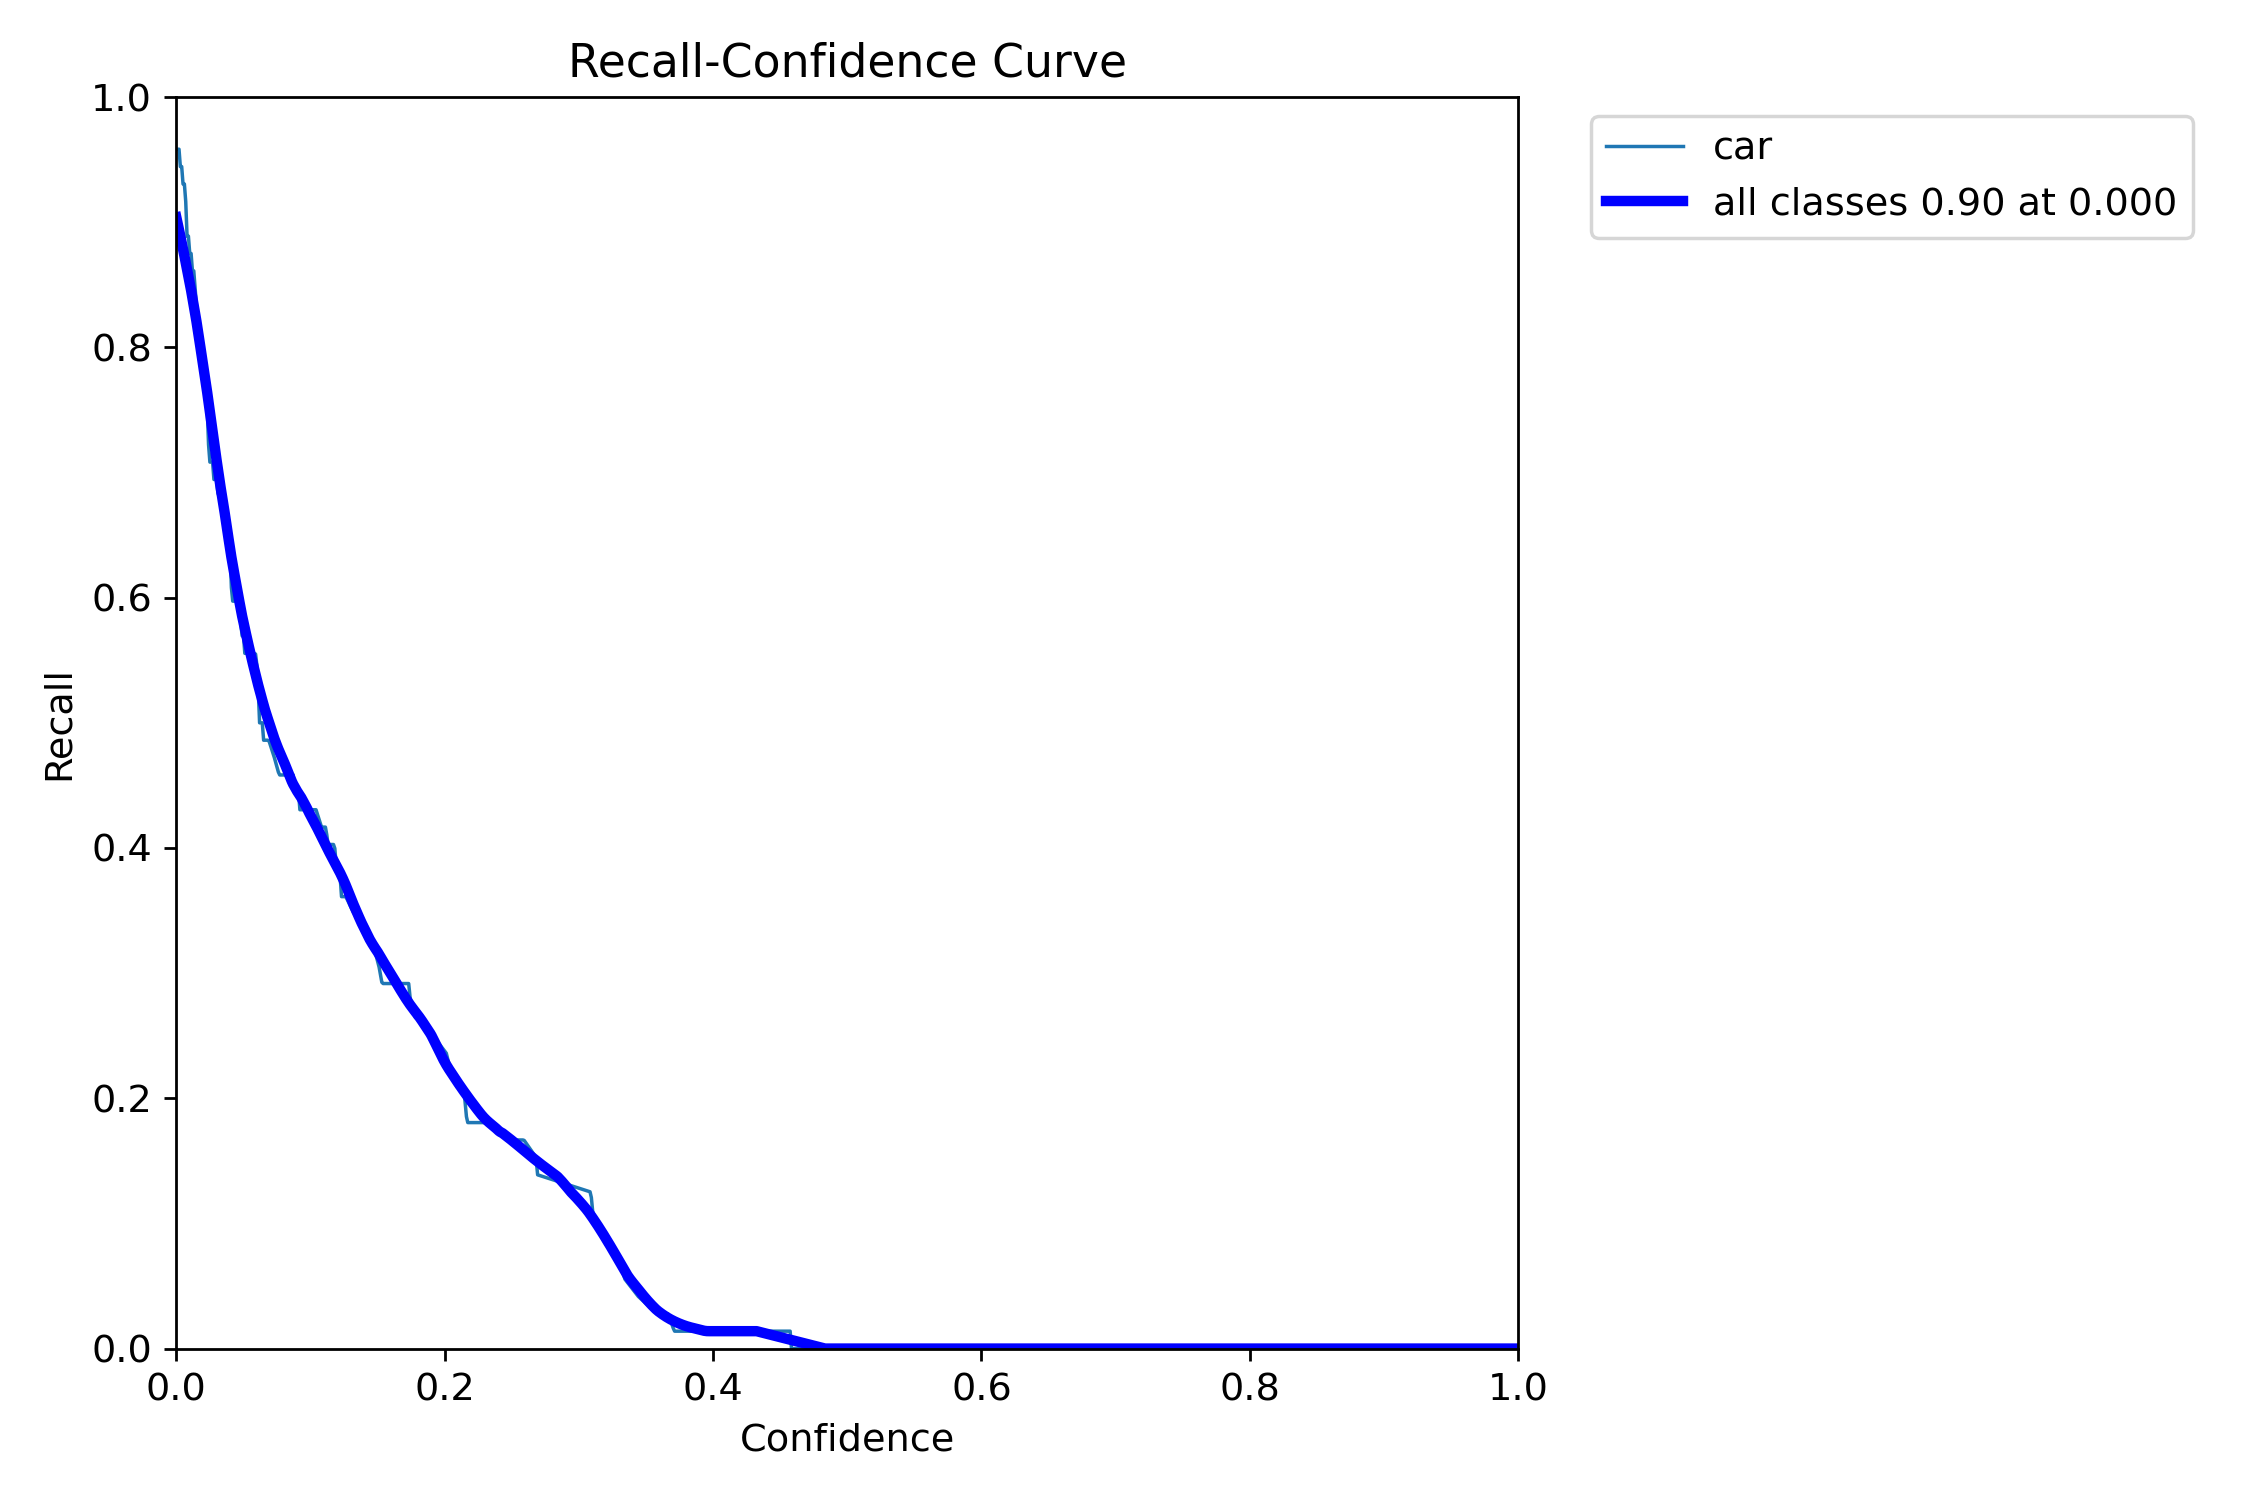

In [10]:
# Change the current working directory to '/content'.
%cd /content
# Display the image 'R_curve.png' from the training output directory.
Image(filename='/content/runs/detect/train/R_curve.png', width=600)


**Conclusions from the Recall-Confidence Curve for YOLOv8n (Nano) Model**

The Recall-Confidence Curve above provides insights into the detection performance of the YOLOv8n (Nano) model on the class 'car'. The curve shows the relationship between recall and the confidence threshold of the model. Key observations include:

- **High Initial Recall**: The model starts with a high recall at low confidence thresholds, which indicates a strong ability to detect the majority of 'car' instances in the dataset.
- **Sharp Decline**: There is a sharp decline in recall as the confidence threshold increases, which suggests that while the model detects most cars at lower confidence levels, it is less confident about these detections.
- **Recall Plateau**: The recall plateaus at higher confidence levels, indicating that only a few detections are highly confident, but these are almost always correct.

These observations suggest that while the Nano model is capable of detecting most 'car' instances, its confidence in these detections varies significantly. This might be due to the smaller and more efficient architecture of the Nano model, which trades off some detection confidence for speed and resource efficiency. For applications where high recall is more critical than high precision, the Nano model may be suitable. However, for use cases requiring high confidence in detections, further model tuning or a different YOLO model variant might be necessary to achieve the desired performance.


/content


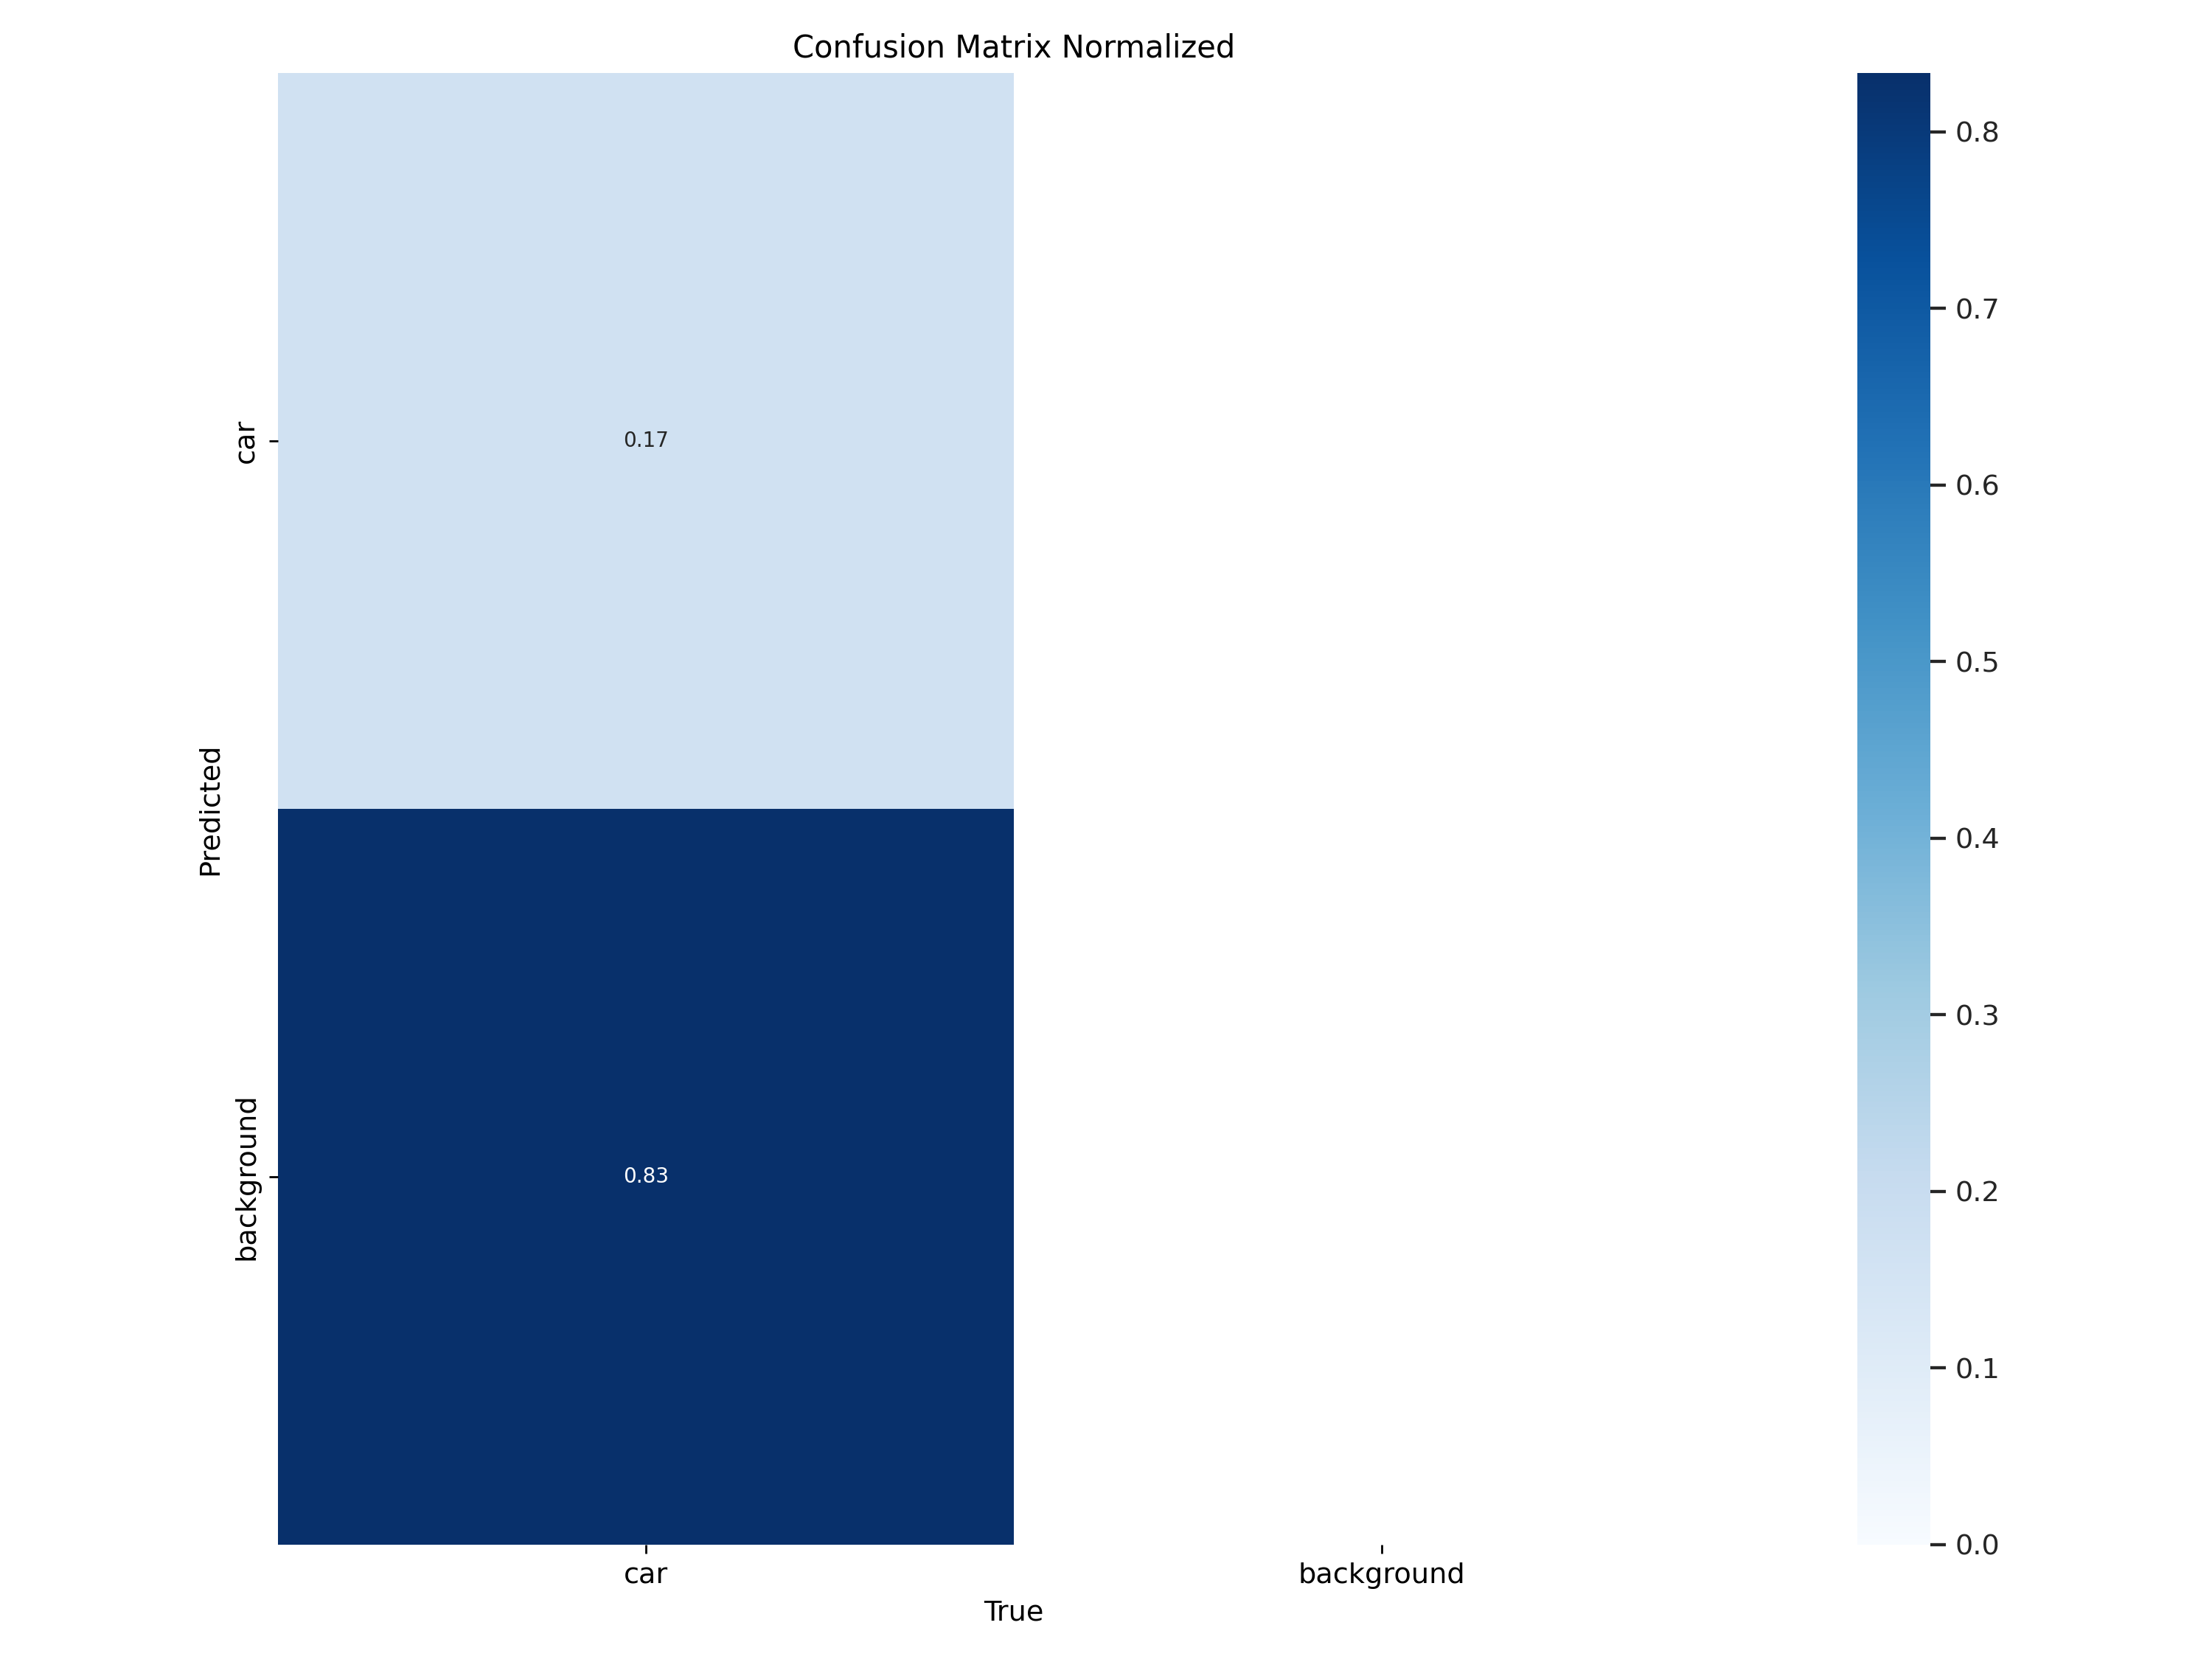

In [11]:
# Navigate to the base '/content' directory. This is a common directory in environments like Google Colab and is often used as a starting point.
%cd /content
# Display the normalized confusion matrix image from the training output.
Image(filename='/content/runs/detect/train/confusion_matrix_normalized.png', width=600)


**Conclusions from the Normalized Confusion Matrix for YOLOv8n (Nano) Model**

The normalized confusion matrix visualized above demonstrates the classification performance of the YOLOv8n (Nano) model on two classes: 'car' and 'background'. The following conclusions can be drawn:

- **High True Negative Rate**: A significant portion of the 'background' class is correctly identified (approximately 83%), indicating that the model is effective at recognizing areas without cars.
- **False Positives**: There is a notable rate of false positives where the 'background' is incorrectly classified as 'car' (approximately 17%). This suggests that the model may sometimes mistake background elements for cars.
- **Precision and Recall Consideration**: While the matrix shows a strong true negative rate, it does not provide direct information about false negatives or true positives for the 'car' class. To fully assess the model's precision and recall for detecting cars, further analysis with additional metrics such as precision-recall curves or F1 scores would be necessary.

This confusion matrix points to a strong ability of the YOLOv8n model to distinguish background in the absence of cars. To improve its performance further, especially in reducing false positives, adjustments to the model's confidence threshold or further training with augmented data might be beneficial. Additionally, a more balanced dataset or an improved feature extraction process could also help in enhancing the model's detection accuracy for the 'car' class.


/content


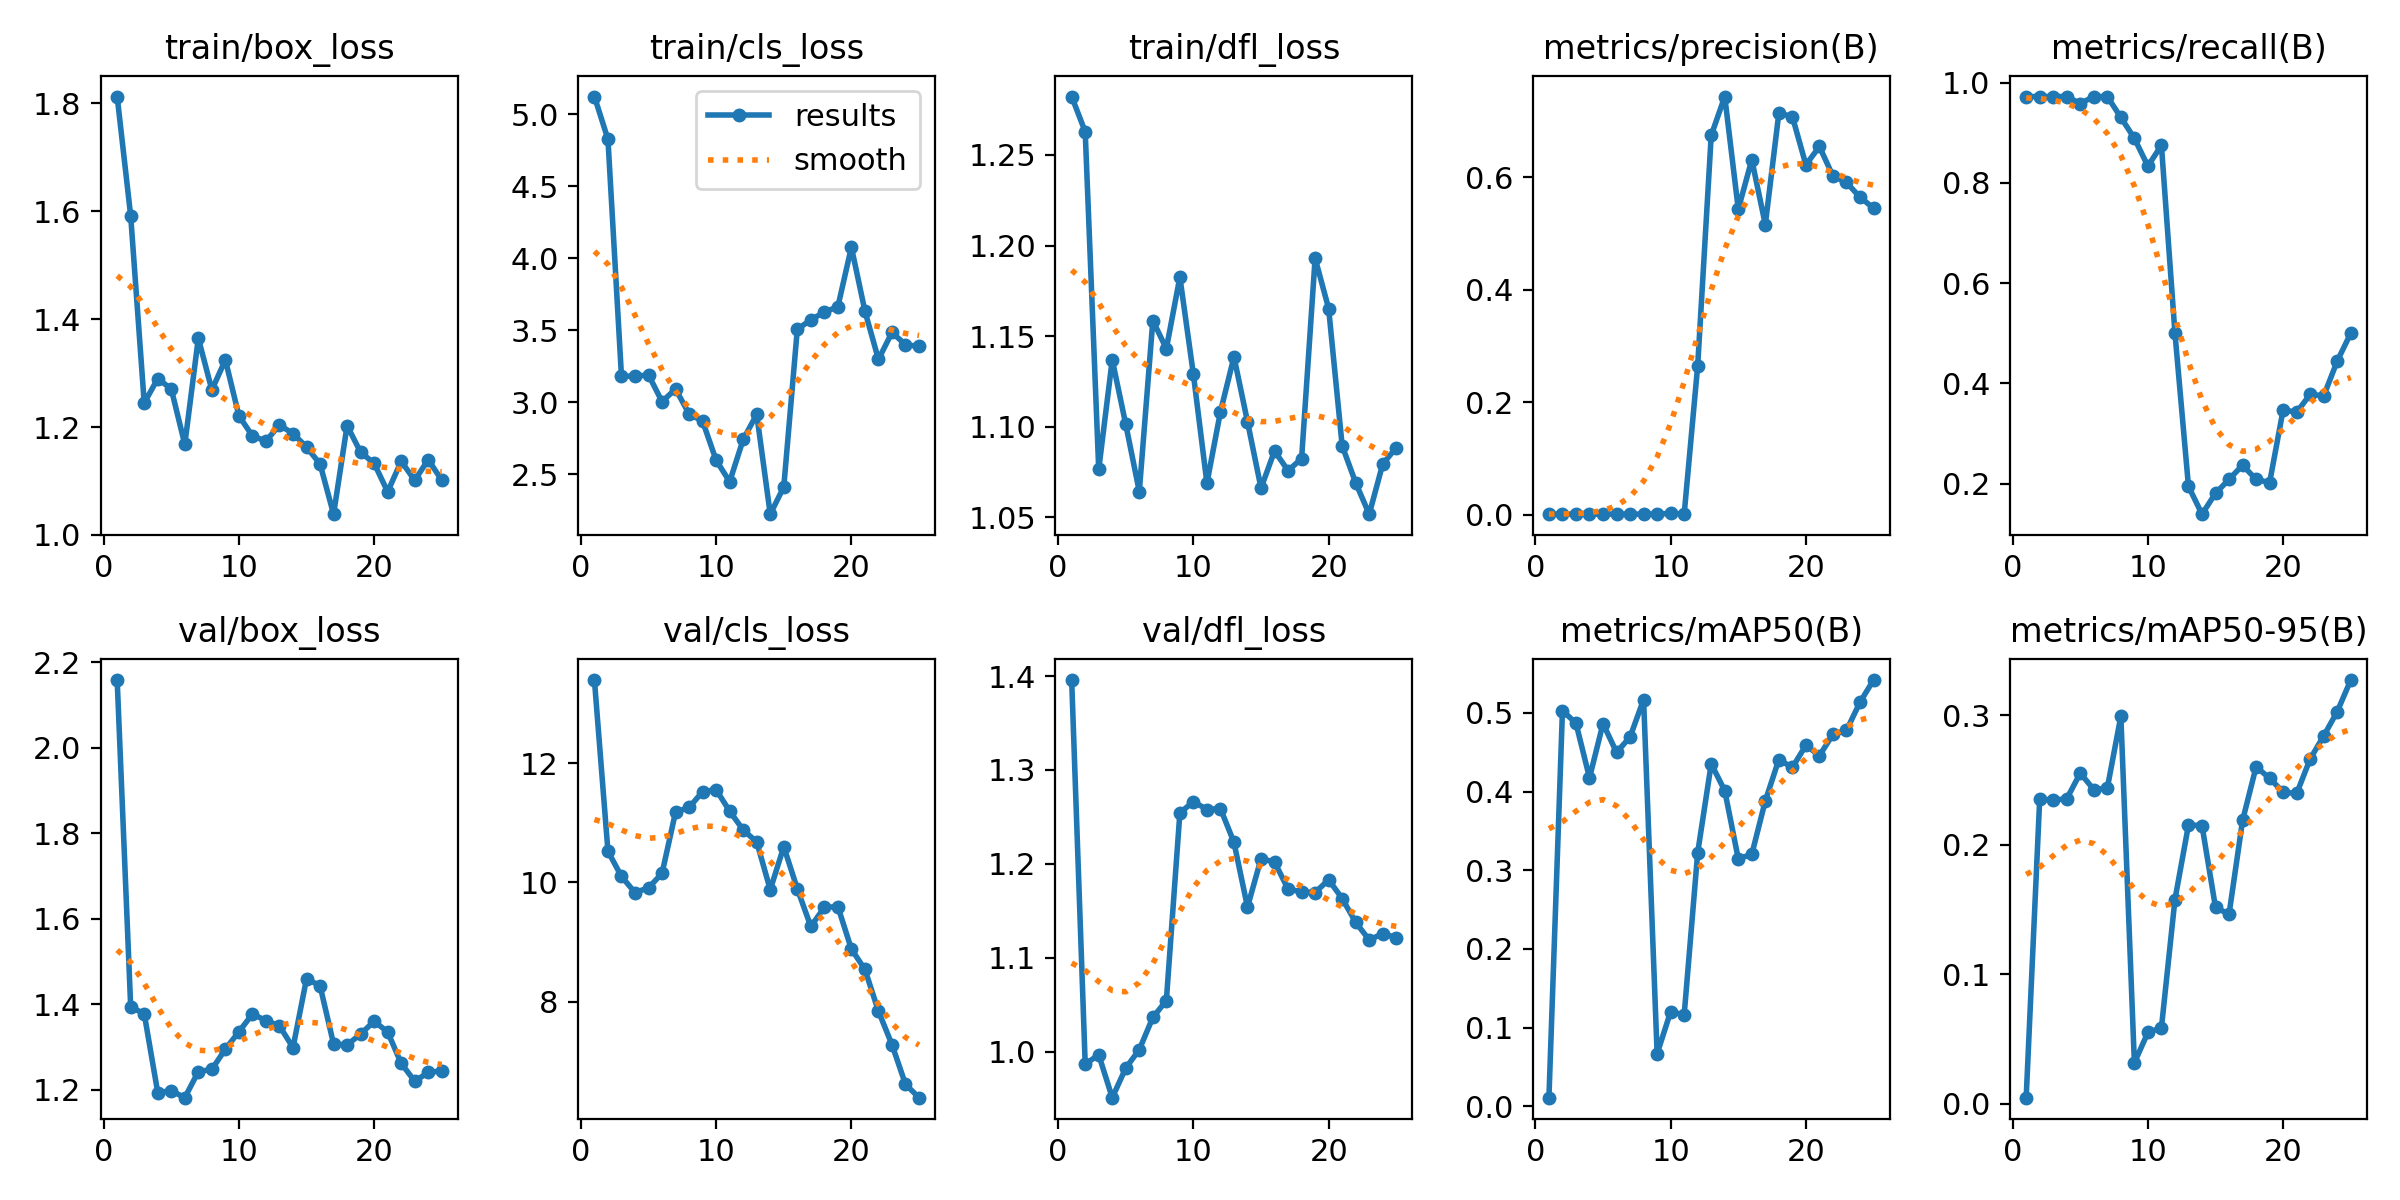

In [12]:
# Navigate to the base '/content' directory.
%cd /content

# Display the results image from the training output.
Image(filename='/content/runs/detect/train/results.png', width=600)


/content


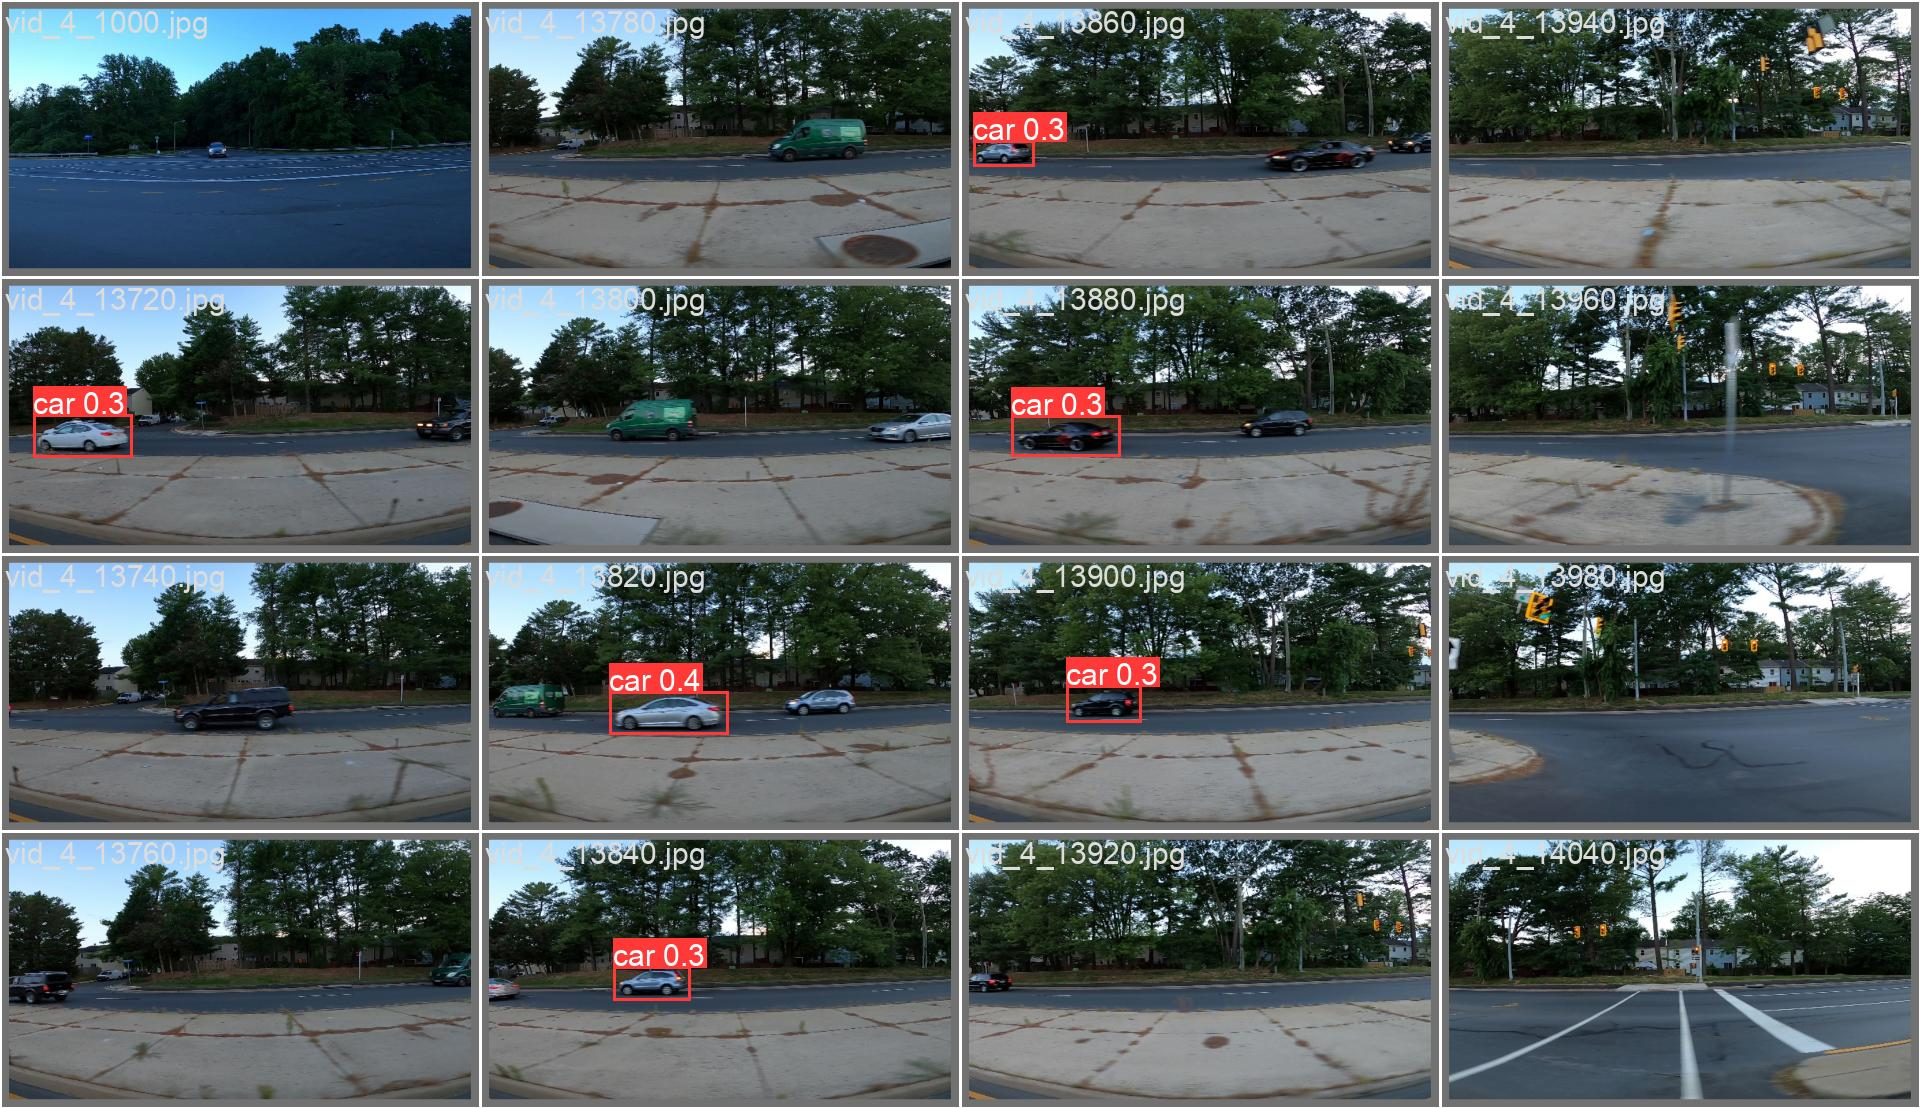

In [13]:
# Change the current working directory to '/content'.
%cd /content

# Display the prediction image for the validation batch 0 from the training output.
# This image is typically one of the predicted outputs generated during the validation phase of the training process.
Image(filename='/content/runs/detect/train/val_batch0_pred.jpg', width=800)


In [14]:
%cd /content
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data={dataset_path}/dataset.yaml

/content
Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/assigment/val.cache... 236 images, 164 backgrounds, 0 corrupt: 100% 236/236 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 15/15 [00:06<00:00,  2.28it/s]
                   all        236         72      0.545        0.5      0.542      0.327
Speed: 2.8ms preprocess, 6.4ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [15]:
%cd /content
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source={dataset_path}/test save=True

/content
Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/175 /content/drive/MyDrive/assigment/test/vid_5_25100.jpg: 480x800 (no detections), 55.5ms
image 2/175 /content/drive/MyDrive/assigment/test/vid_5_25120.jpg: 480x800 (no detections), 26.0ms
image 3/175 /content/drive/MyDrive/assigment/test/vid_5_25140.jpg: 480x800 (no detections), 9.7ms
image 4/175 /content/drive/MyDrive/assigment/test/vid_5_25160.jpg: 480x800 (no detections), 9.1ms
image 5/175 /content/drive/MyDrive/assigment/test/vid_5_25180.jpg: 480x800 (no detections), 8.2ms
image 6/175 /content/drive/MyDrive/assigment/test/vid_5_25200.jpg: 480x800 (no detections), 9.5ms
image 7/175 /content/drive/MyDrive/assigment/test/vid_5_25220.jpg: 480x800 (no detections), 9.2ms
image 8/175 /content/drive/MyDrive/assigment/test/vid_5_25240.jpg: 480x800 (no detections), 7.7ms
image 9/175 /content/drive/MyDrive/ass

In [16]:
%pwd

'/content'

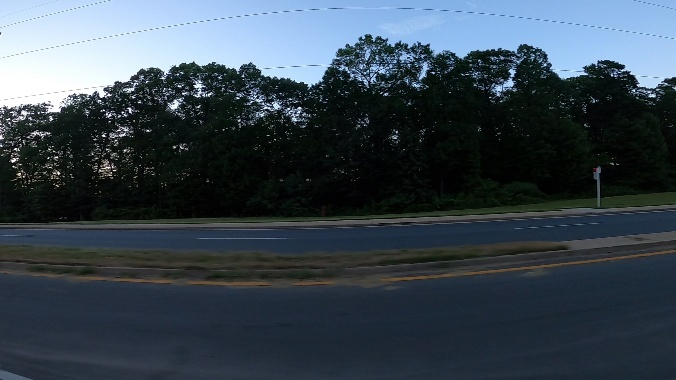

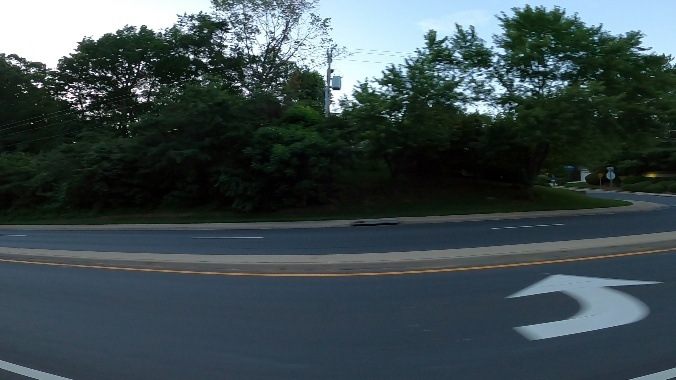

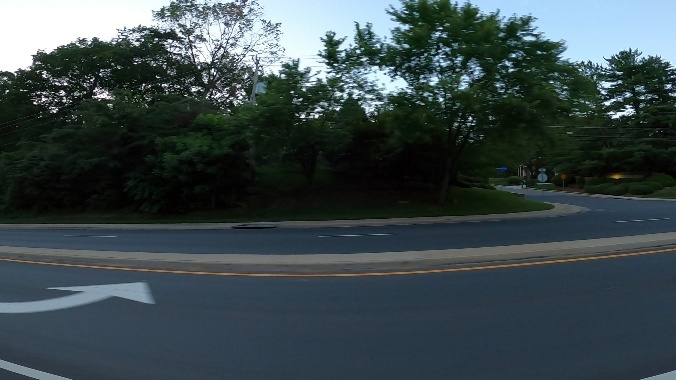

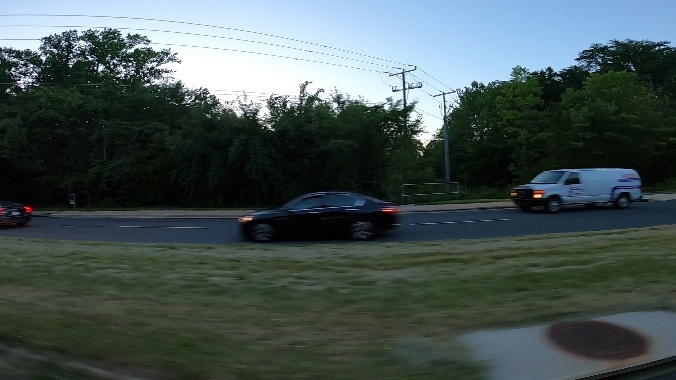

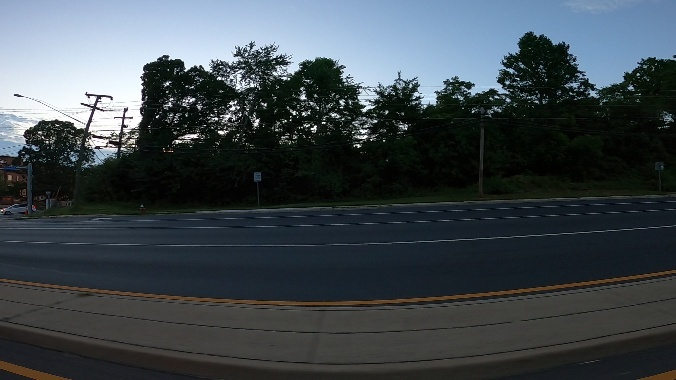

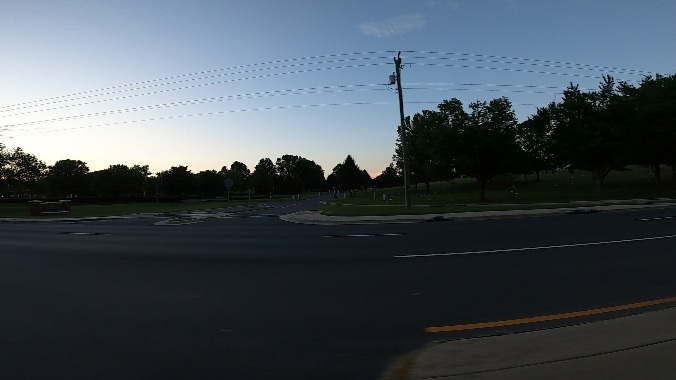

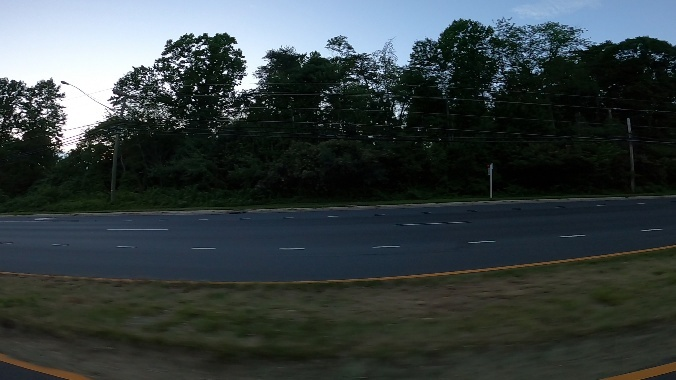

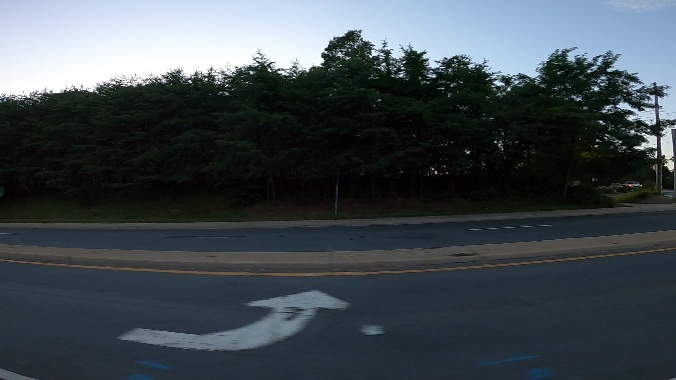

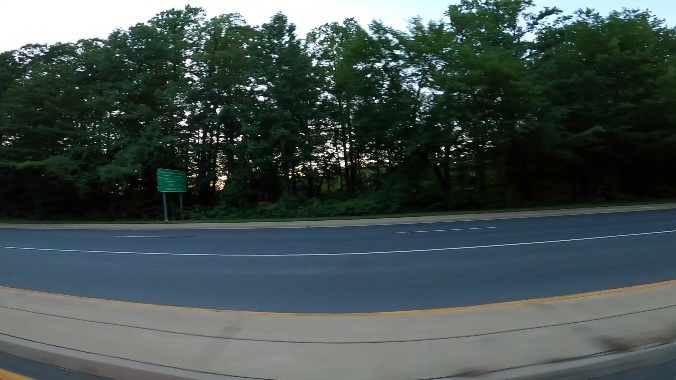

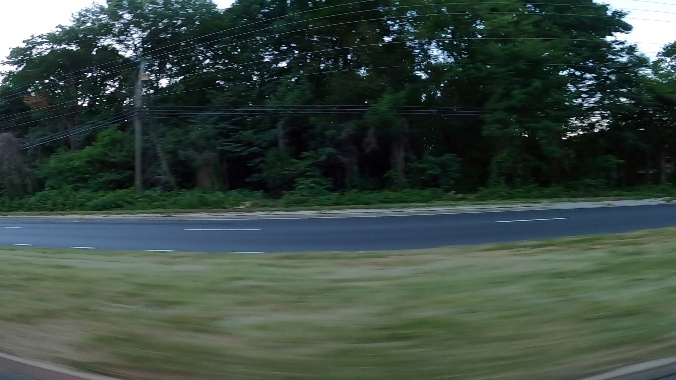

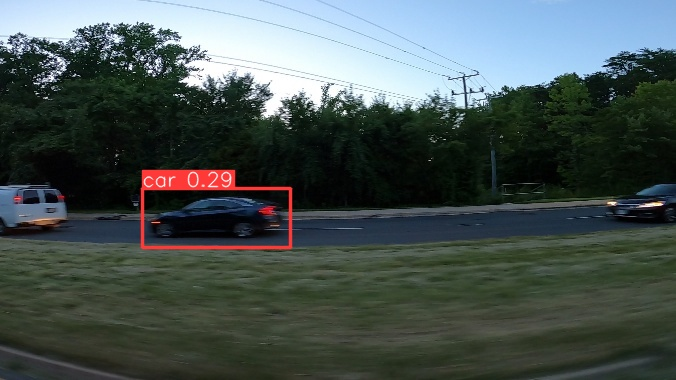

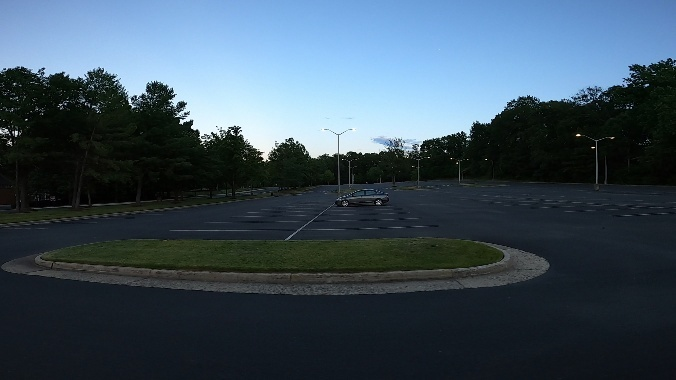

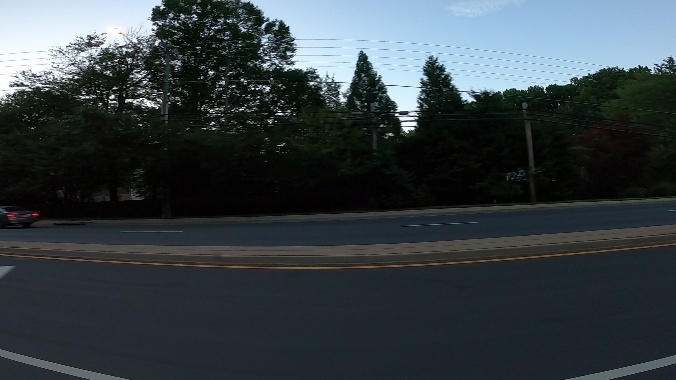

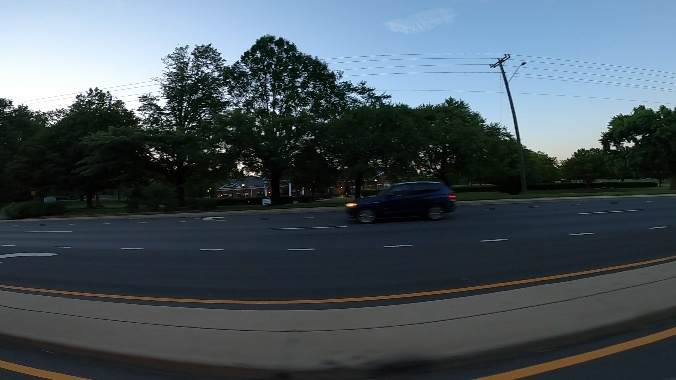

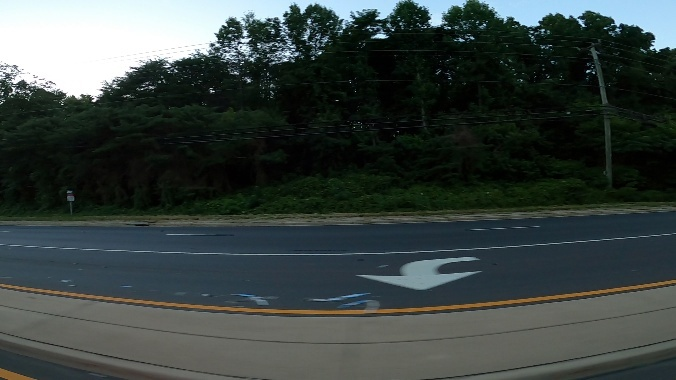

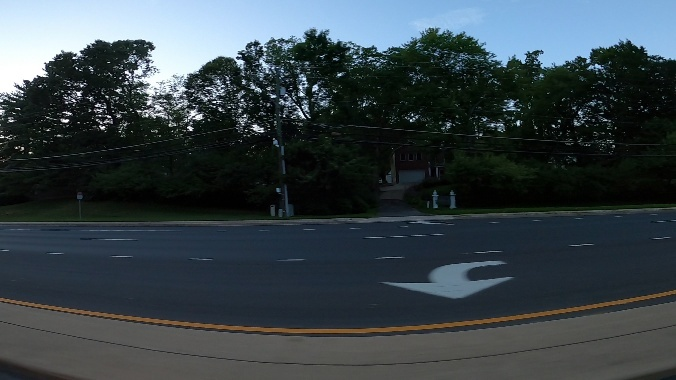

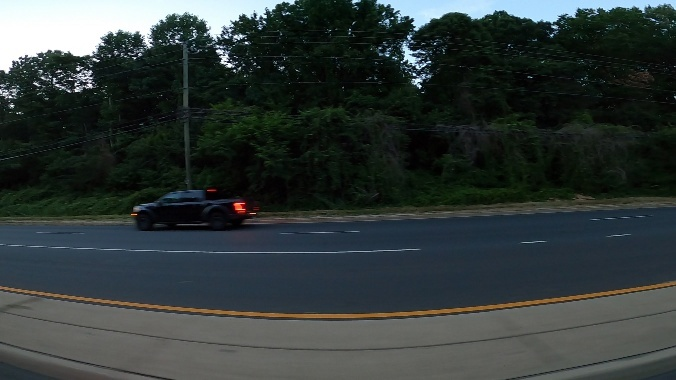

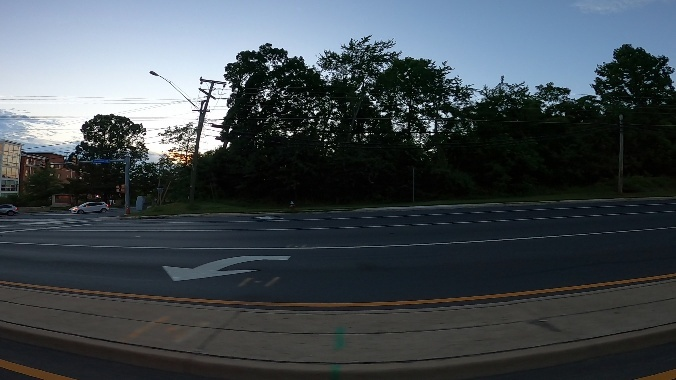

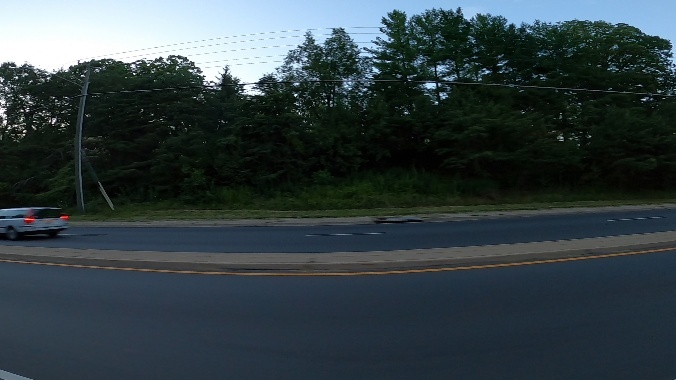

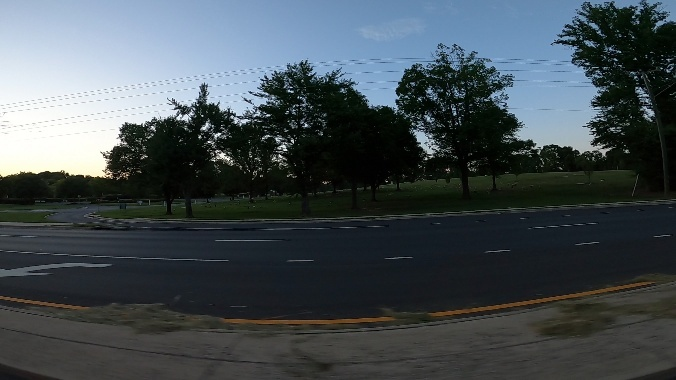

In [17]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:20]:
      display(Image(filename=image_path, width=400))
      print("\n")

### 3.2 YOLOv8s (Small) Model Training

The Small model aims to strike a balance between speed and accuracy. It's potentially more accurate than the Nano model but less efficient. This section covers the training details and expectations for the YOLOv8s model.


In [18]:
!yolo task=detect mode=train model=yolov8s.pt data={dataset_path}/dataset.yaml epochs=25 batch=16 imgsz=800 save=True cache=True device=cuda:0 workers=8 single_cls=True amp=True val=True plots=True


100% 21.5M/21.5M [00:00<00:00, 165MB/s]
Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/assigment/dataset.yaml, epochs=25, time=None, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=True, device=cuda:0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fals

In [19]:
#check content in folder
!ls

drive  runs  yolov8n.pt  yolov8s.pt


In [20]:
!ls /content/runs/detect/train2

args.yaml					    R_curve.png        val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv        val_batch0_pred.jpg
confusion_matrix.png				    results.png        val_batch1_labels.jpg
events.out.tfevents.1707306297.36876801e9a7.4052.0  train_batch0.jpg   val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch2.jpg   val_batch2_pred.jpg
labels.jpg					    train_batch75.jpg  weights
P_curve.png					    train_batch76.jpg
PR_curve.png					    train_batch77.jpg


/content


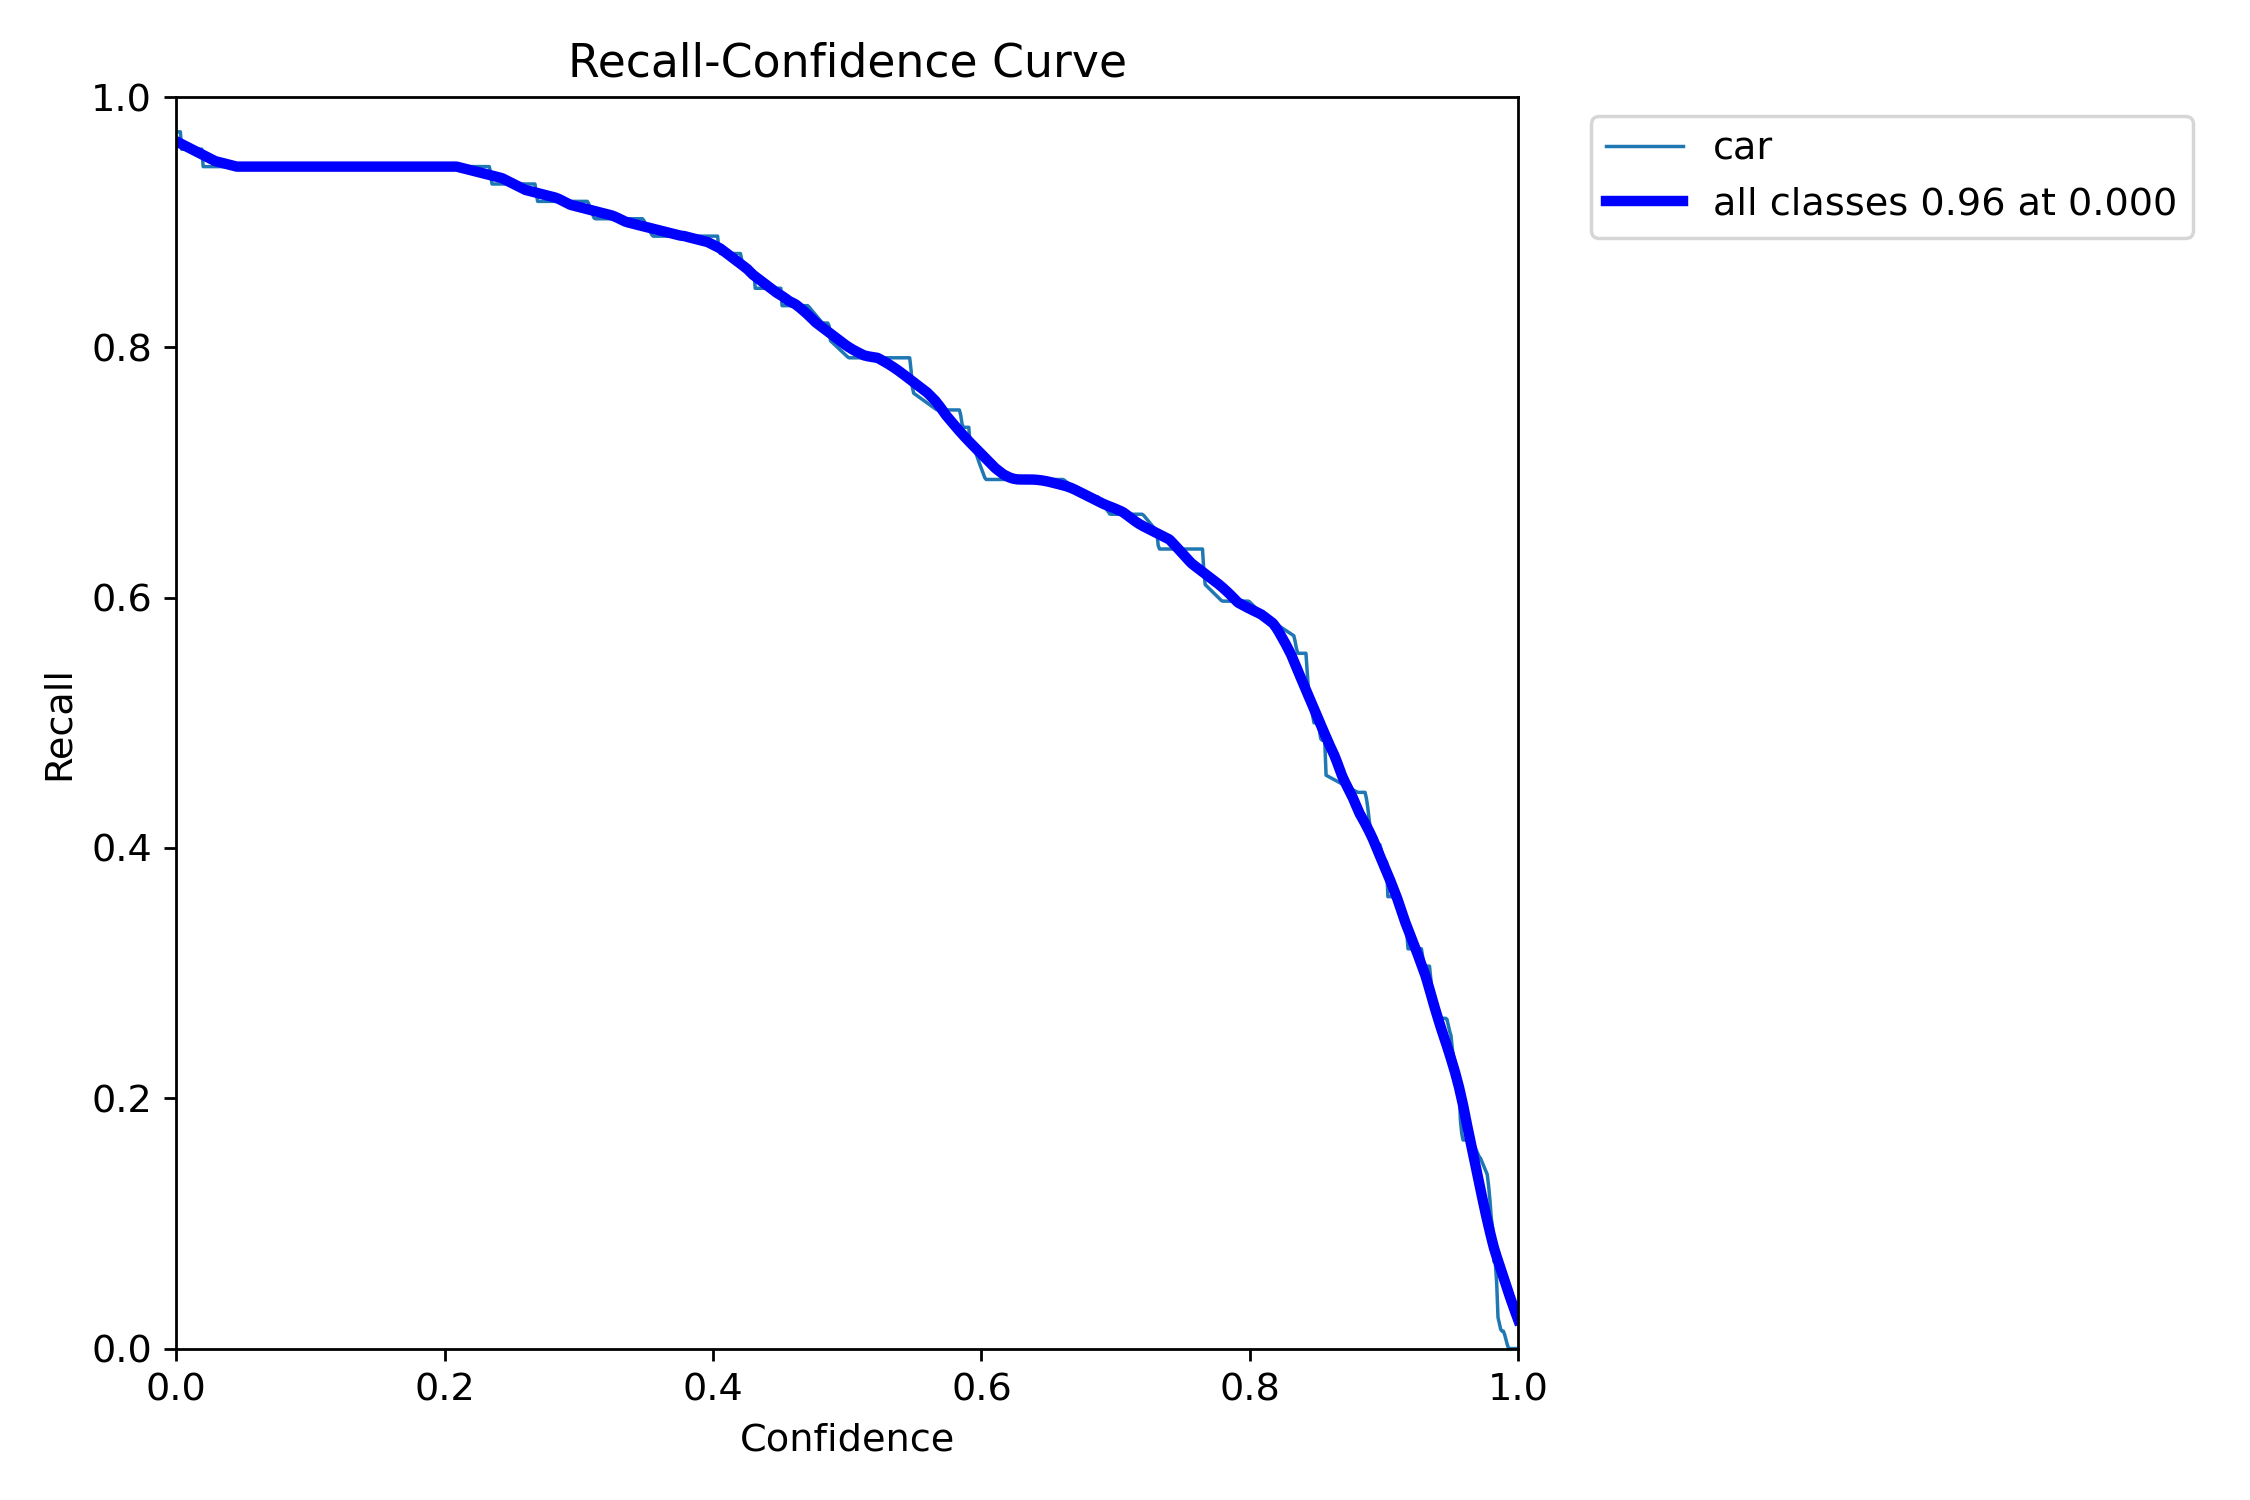

In [21]:
%cd /content
Image(filename=f'/content/runs/detect/train2/R_curve.png', width=600)

/content


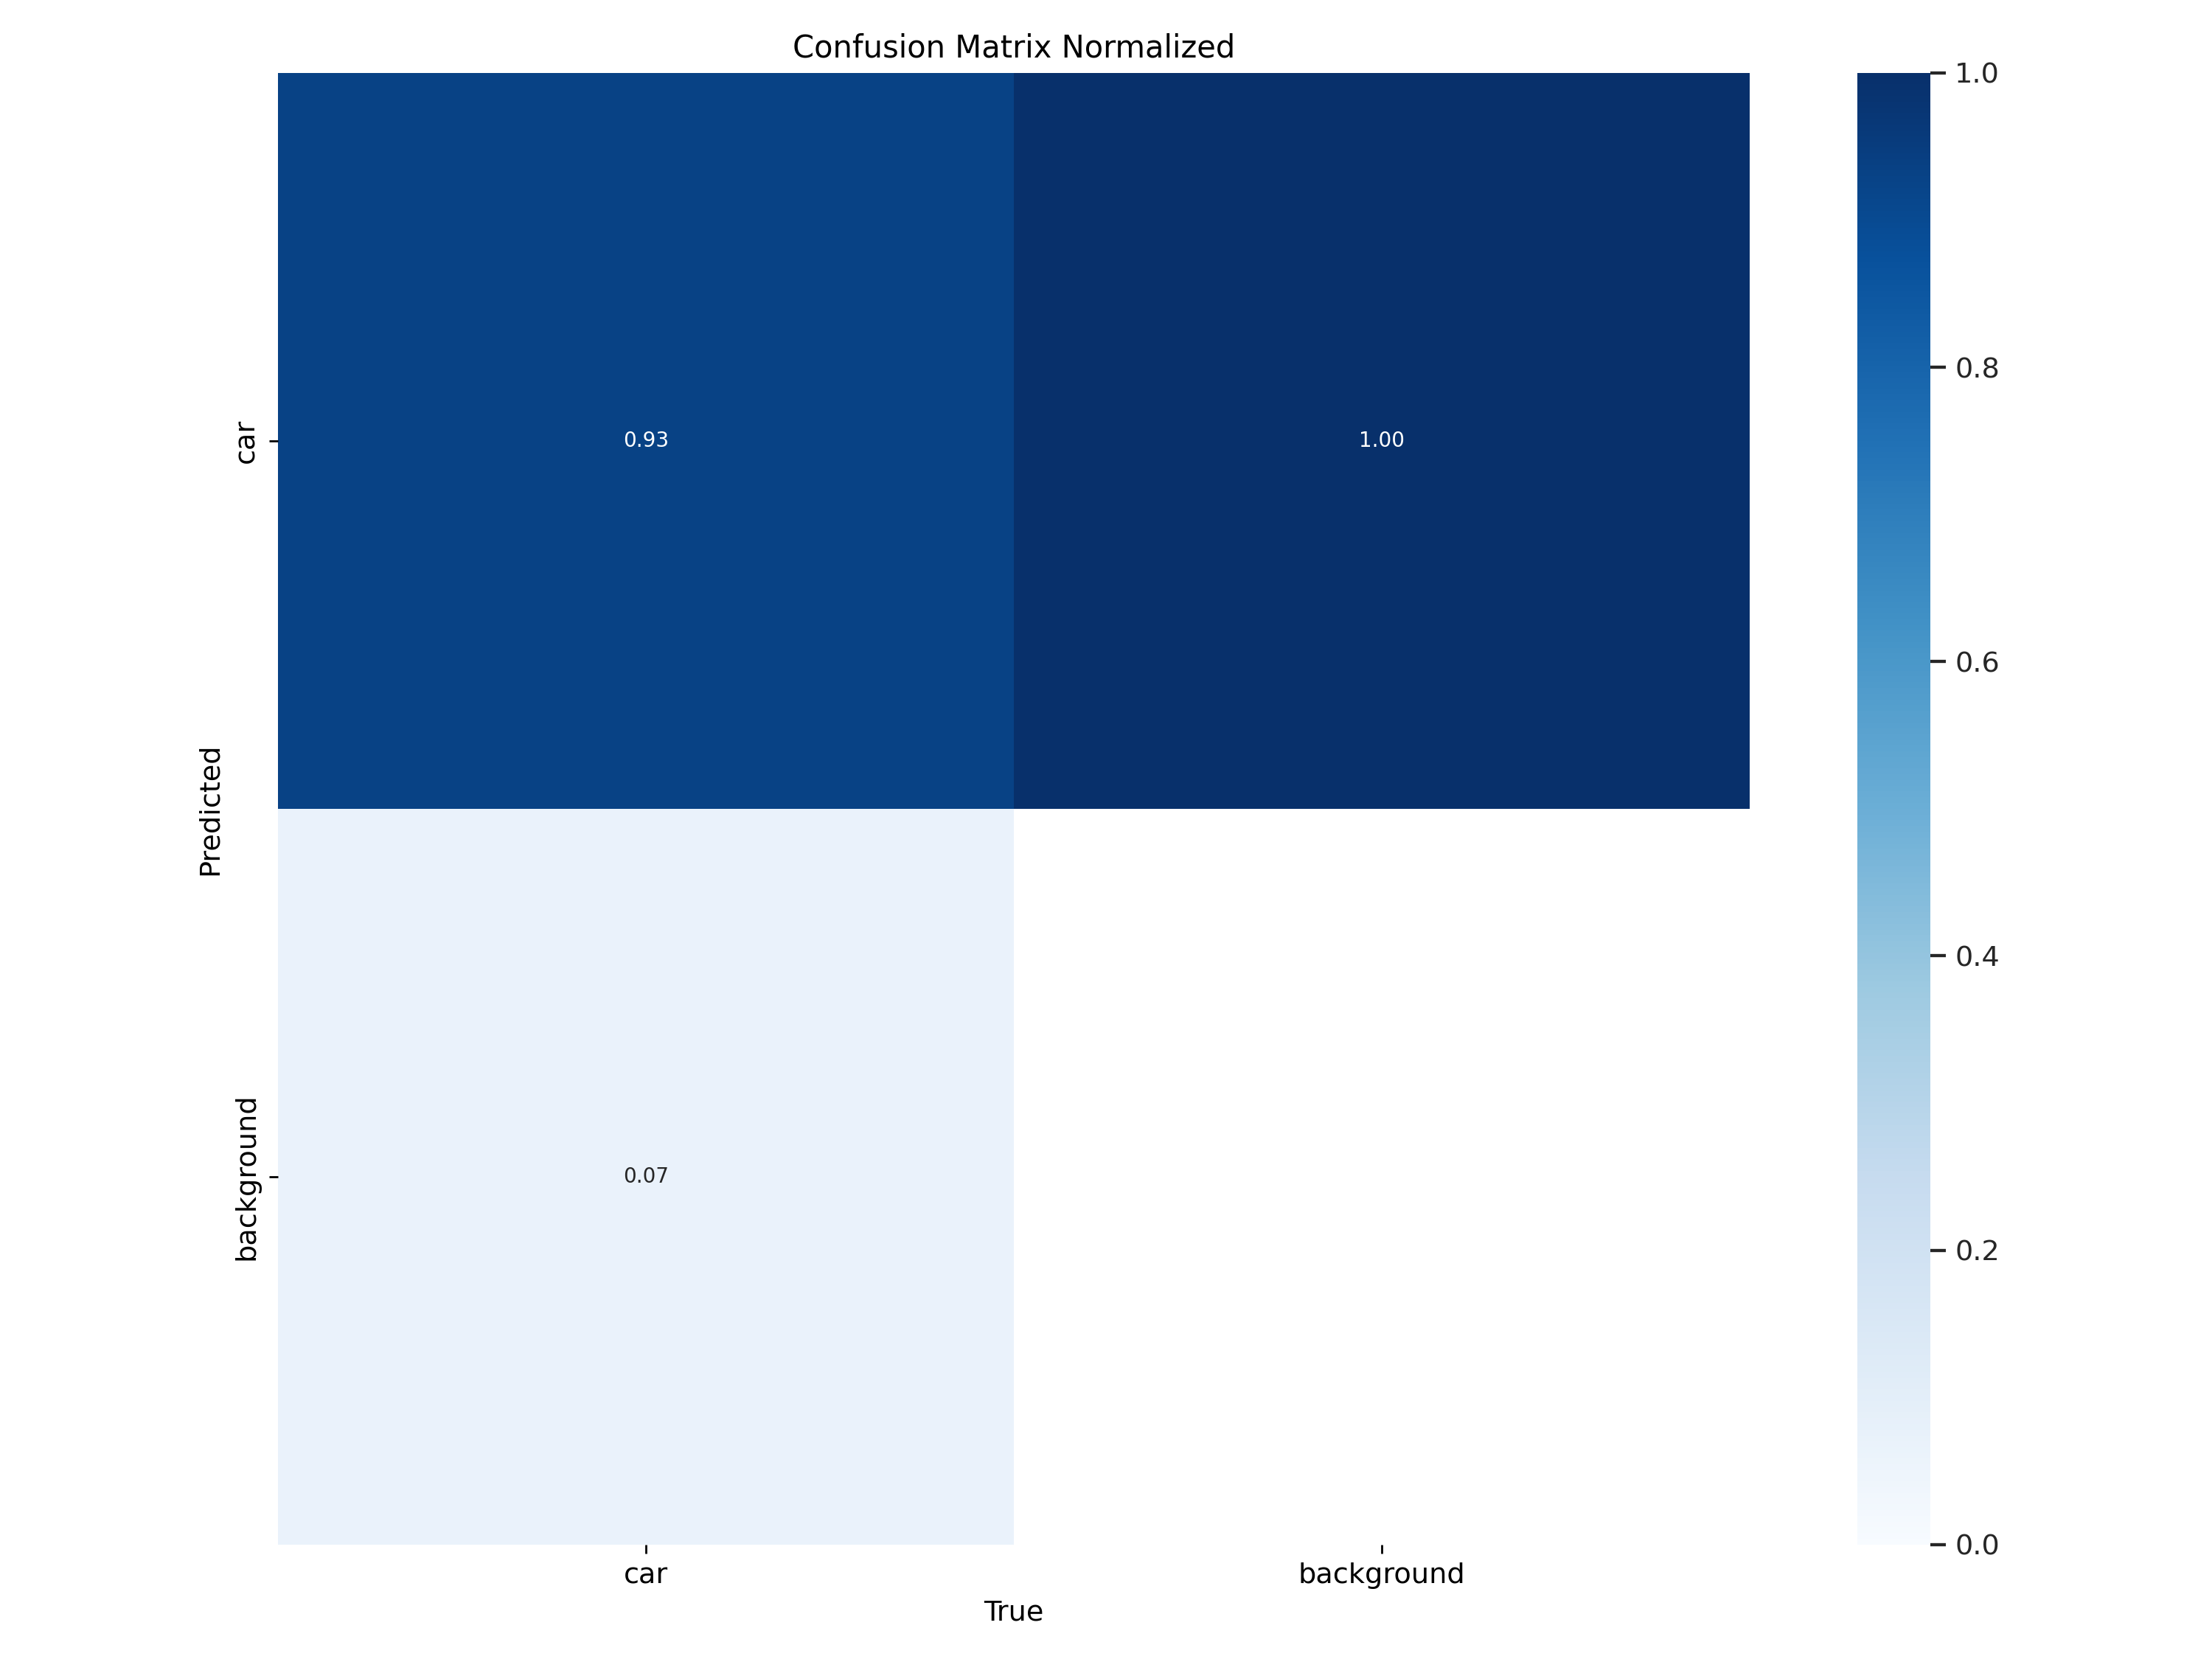

In [22]:
%cd /content
Image(filename=f'/content/runs/detect/train2/confusion_matrix_normalized.png', width=600)

/content


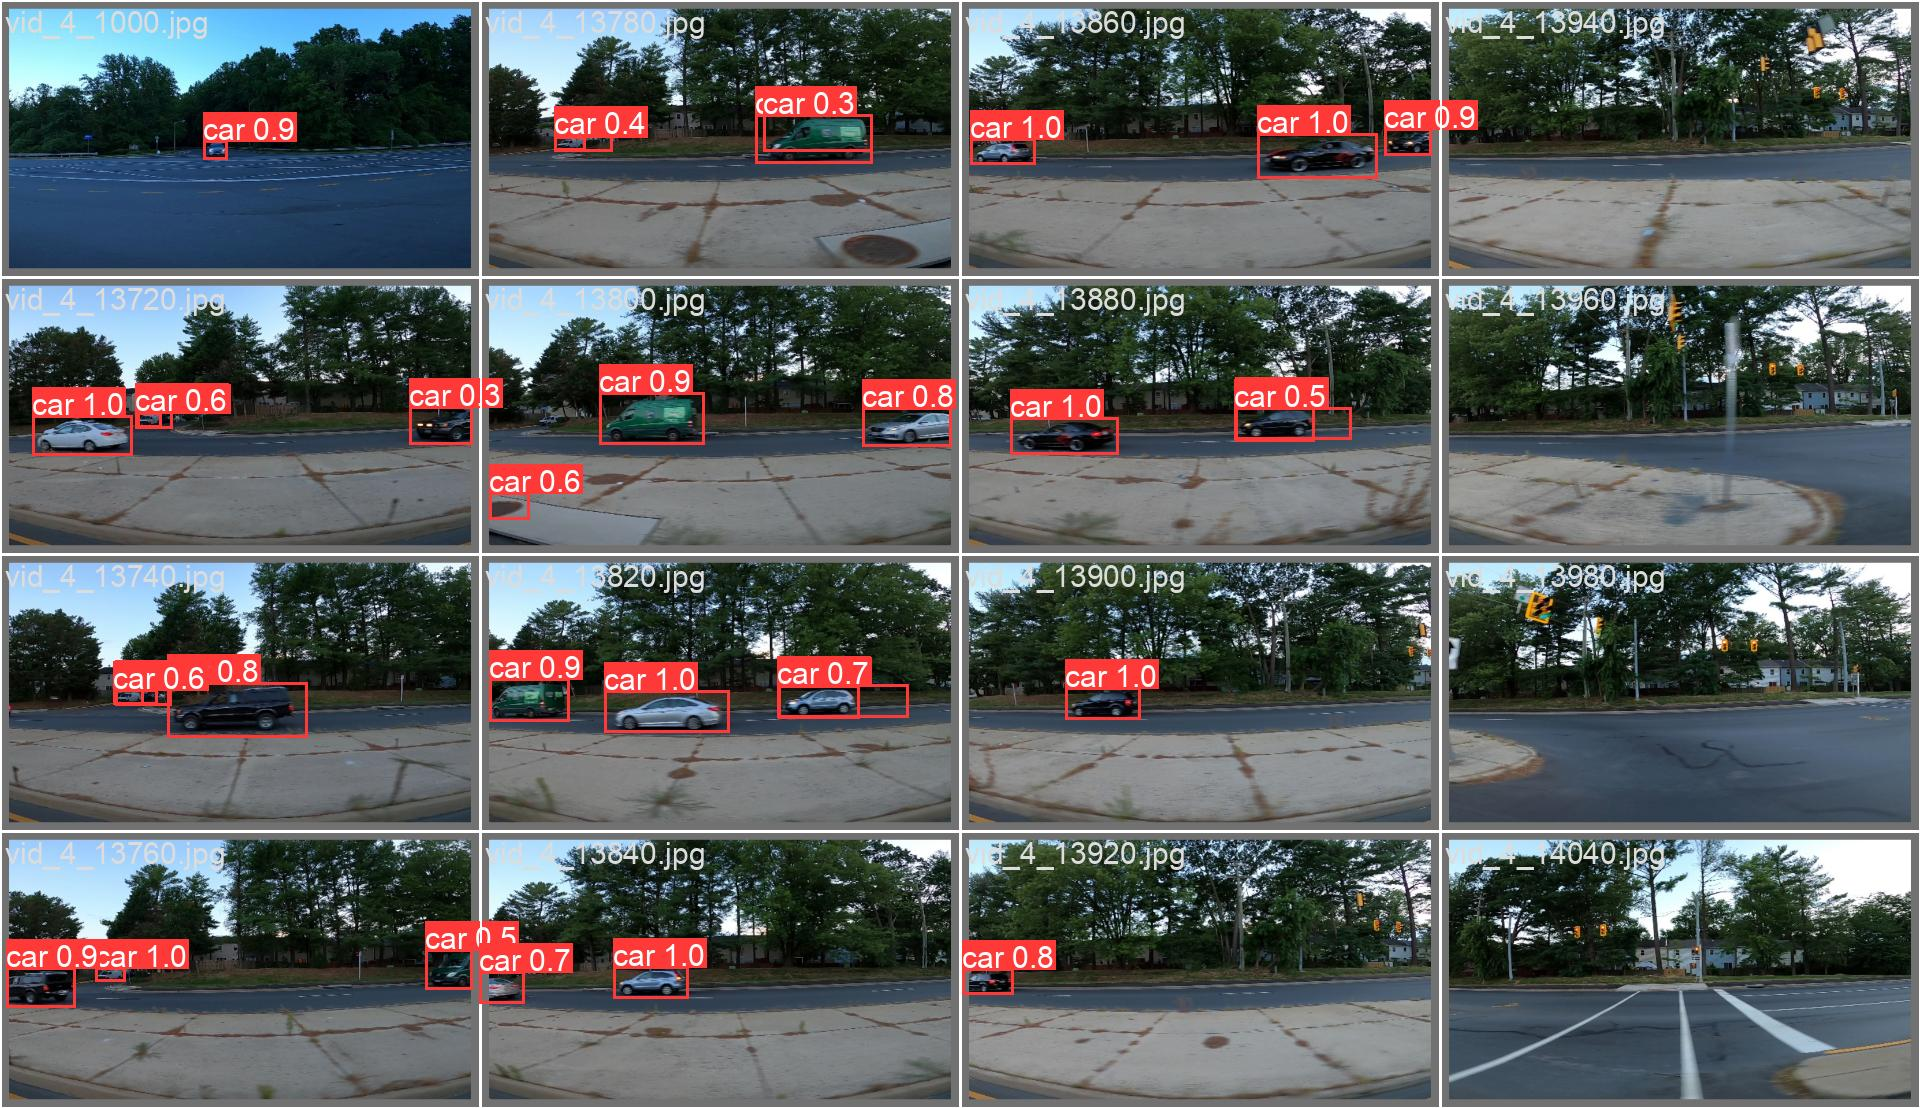

In [23]:
%cd /content
Image(filename=f'/content/runs/detect/train2/val_batch0_pred.jpg', width=800)

In [24]:
%cd /content

!yolo task=detect mode=val model=/content/runs/detect/train2/weights/best.pt data={dataset_path}/dataset.yaml

/content
Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/drive/MyDrive/assigment/val.cache... 236 images, 164 backgrounds, 0 corrupt: 100% 236/236 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 15/15 [00:08<00:00,  1.74it/s]
                   all        236         72      0.465       0.75      0.498      0.261
Speed: 4.1ms preprocess, 9.5ms inference, 0.0ms loss, 8.8ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


In [25]:
%cd /content
!yolo task=detect mode=predict model=/content/runs/detect/train2/weights/best.pt conf=0.25 source={dataset_path}/test save=True

/content
Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

image 1/175 /content/drive/MyDrive/assigment/test/vid_5_25100.jpg: 480x800 (no detections), 104.1ms
image 2/175 /content/drive/MyDrive/assigment/test/vid_5_25120.jpg: 480x800 (no detections), 15.8ms
image 3/175 /content/drive/MyDrive/assigment/test/vid_5_25140.jpg: 480x800 (no detections), 15.7ms
image 4/175 /content/drive/MyDrive/assigment/test/vid_5_25160.jpg: 480x800 (no detections), 15.7ms
image 5/175 /content/drive/MyDrive/assigment/test/vid_5_25180.jpg: 480x800 1 car, 15.7ms
image 6/175 /content/drive/MyDrive/assigment/test/vid_5_25200.jpg: 480x800 1 car, 15.7ms
image 7/175 /content/drive/MyDrive/assigment/test/vid_5_25220.jpg: 480x800 1 car, 15.6ms
image 8/175 /content/drive/MyDrive/assigment/test/vid_5_25240.jpg: 480x800 1 car, 15.6ms
image 9/175 /content/drive/MyDrive/assigment/test/vid_5_25260.jpg: 48

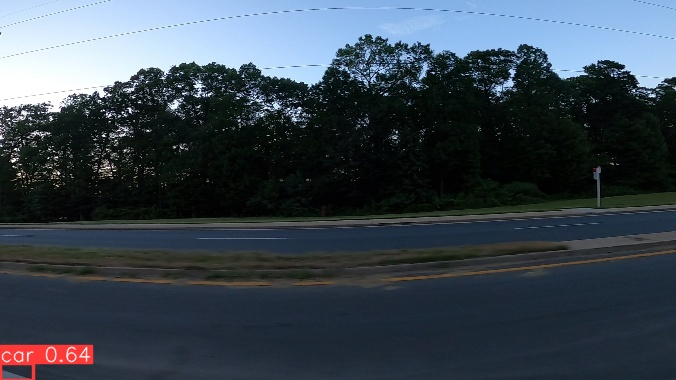

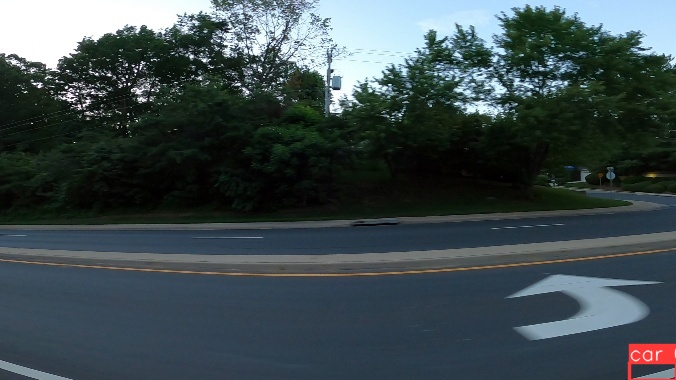

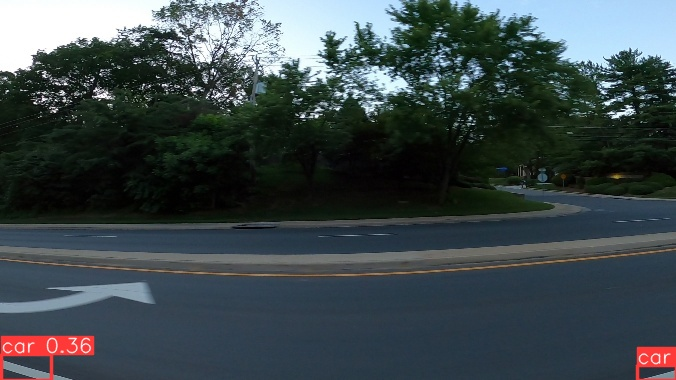

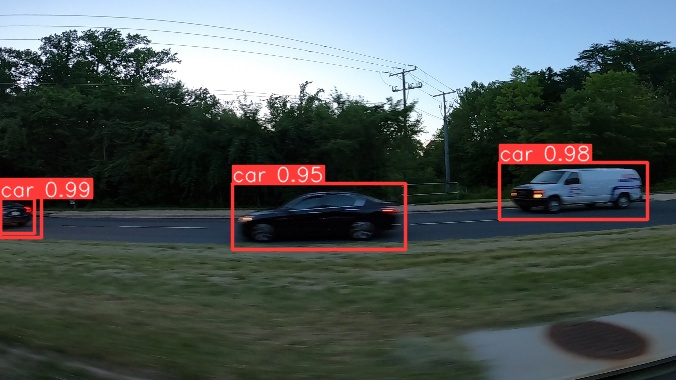

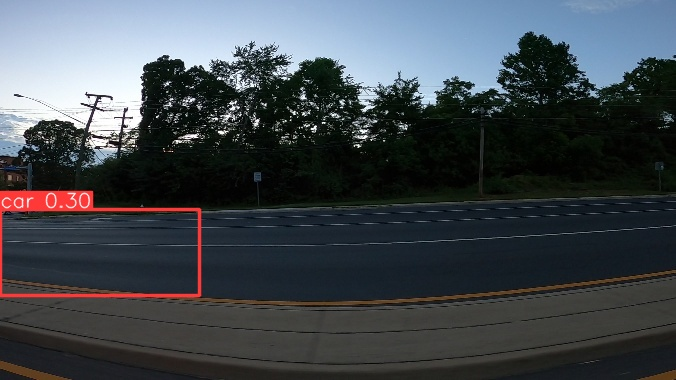

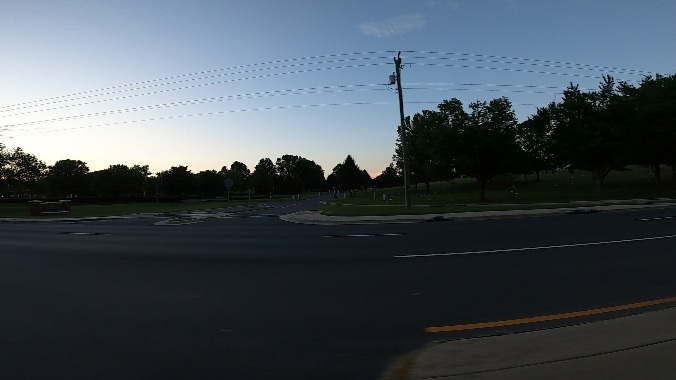

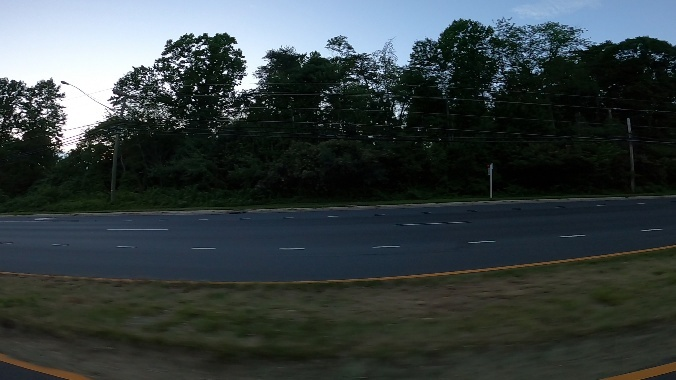

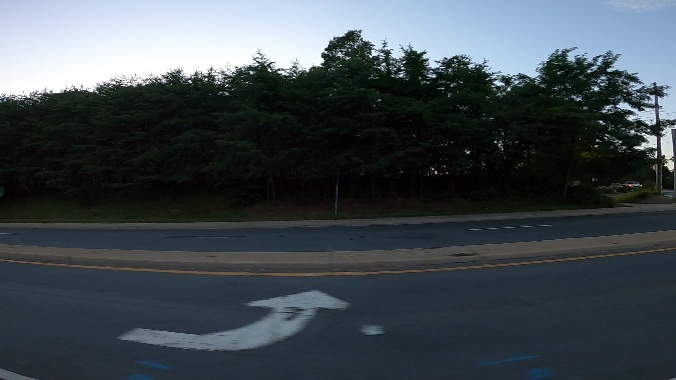

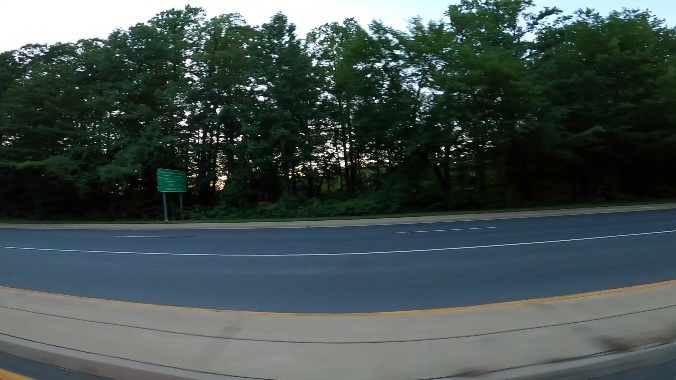

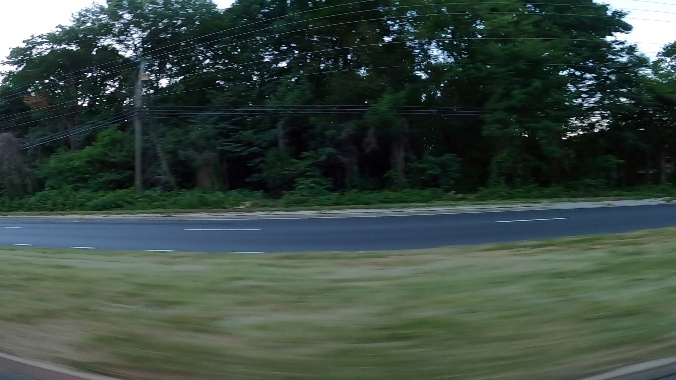

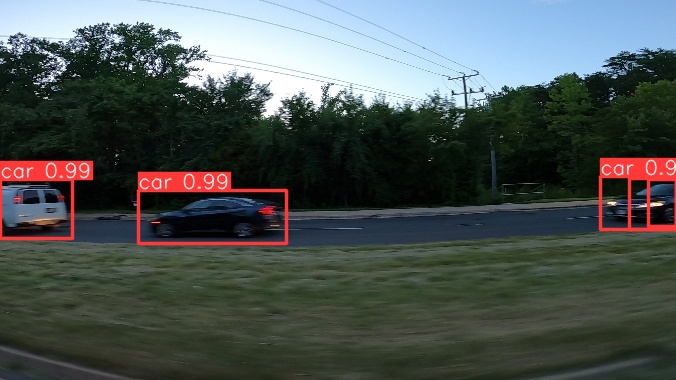

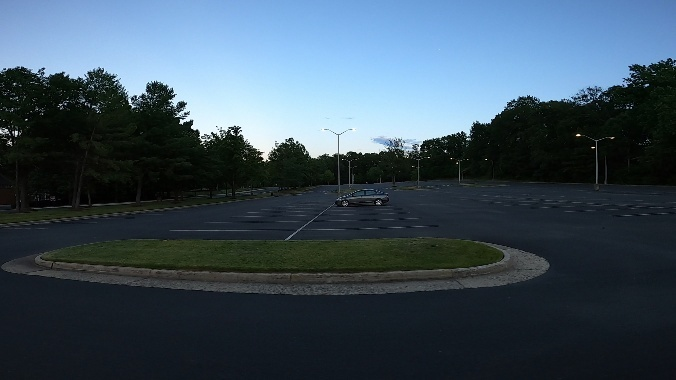

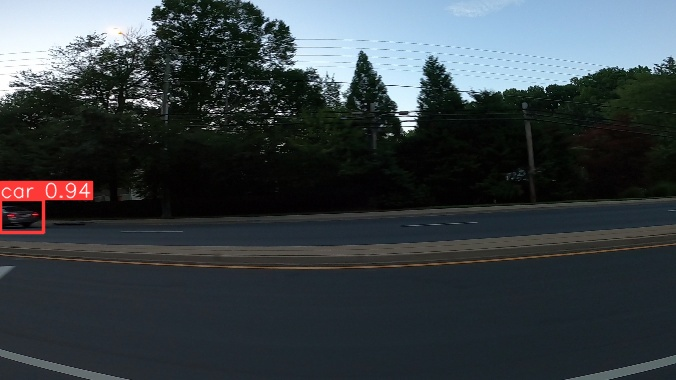

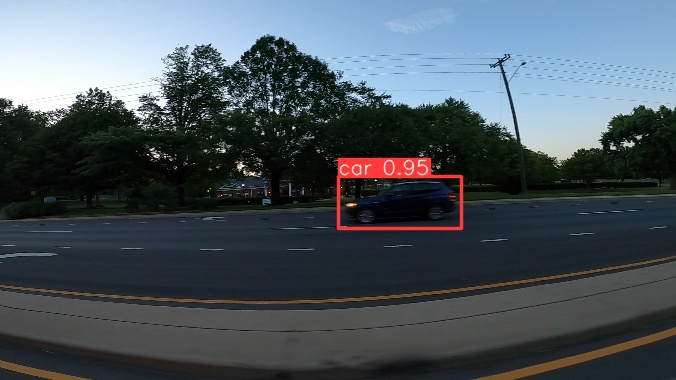

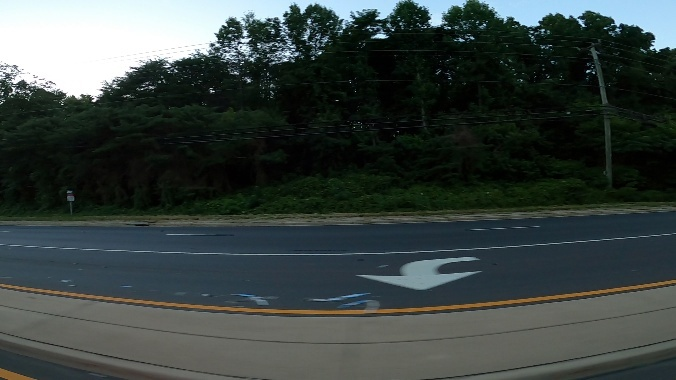

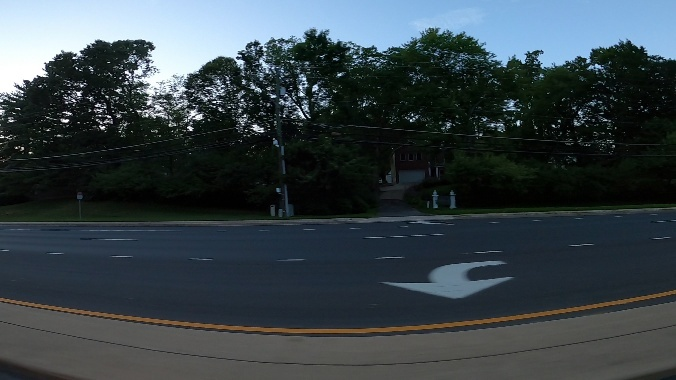

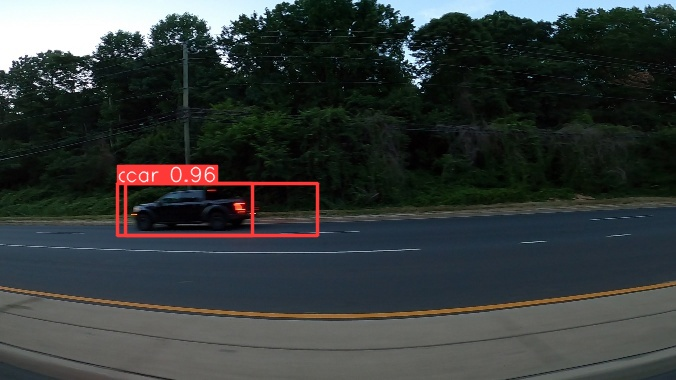

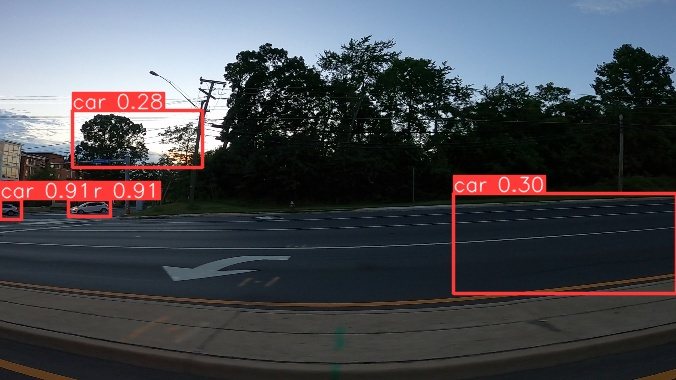

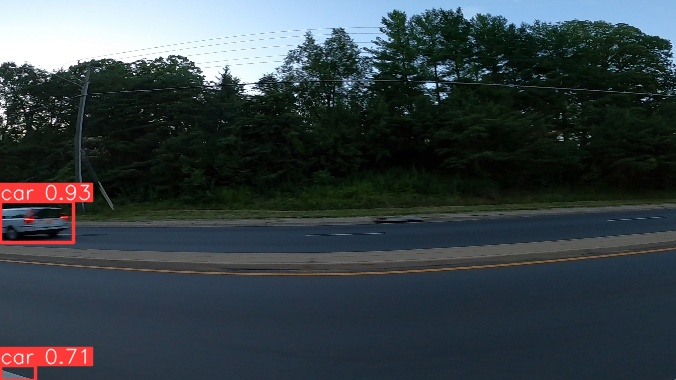

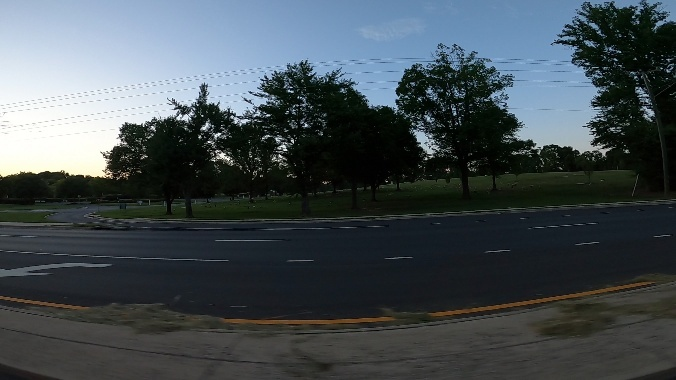

In [26]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/runs/detect/predict2/*.jpg')[:20]:
      display(Image(filename=image_path, width=600))
      print("\n")

### 3.3 YOLOv8m (Medium) Model Training

The Medium model is designed for scenarios where accuracy is paramount, possibly at the expense of speed and computational efficiency. This section will detail the training process for the YOLOv8m model and set expectations for its performance.


In [27]:
!yolo task=detect mode=train model=yolov8m.pt data={dataset_path}/dataset.yaml epochs=25 batch=16 imgsz=800 save=True cache=True device=cuda:0 workers=8 single_cls=True amp=True val=True plots=True


100% 49.7M/49.7M [00:00<00:00, 222MB/s]
Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/assigment/dataset.yaml, epochs=25, time=None, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=True, device=cuda:0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fals

In [28]:
!ls /content/runs/detect/train3

args.yaml					    R_curve.png        val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv        val_batch0_pred.jpg
confusion_matrix.png				    results.png        val_batch1_labels.jpg
events.out.tfevents.1707306686.36876801e9a7.5811.0  train_batch0.jpg   val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg   val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch2.jpg   val_batch2_pred.jpg
labels.jpg					    train_batch75.jpg  weights
P_curve.png					    train_batch76.jpg
PR_curve.png					    train_batch77.jpg


/content


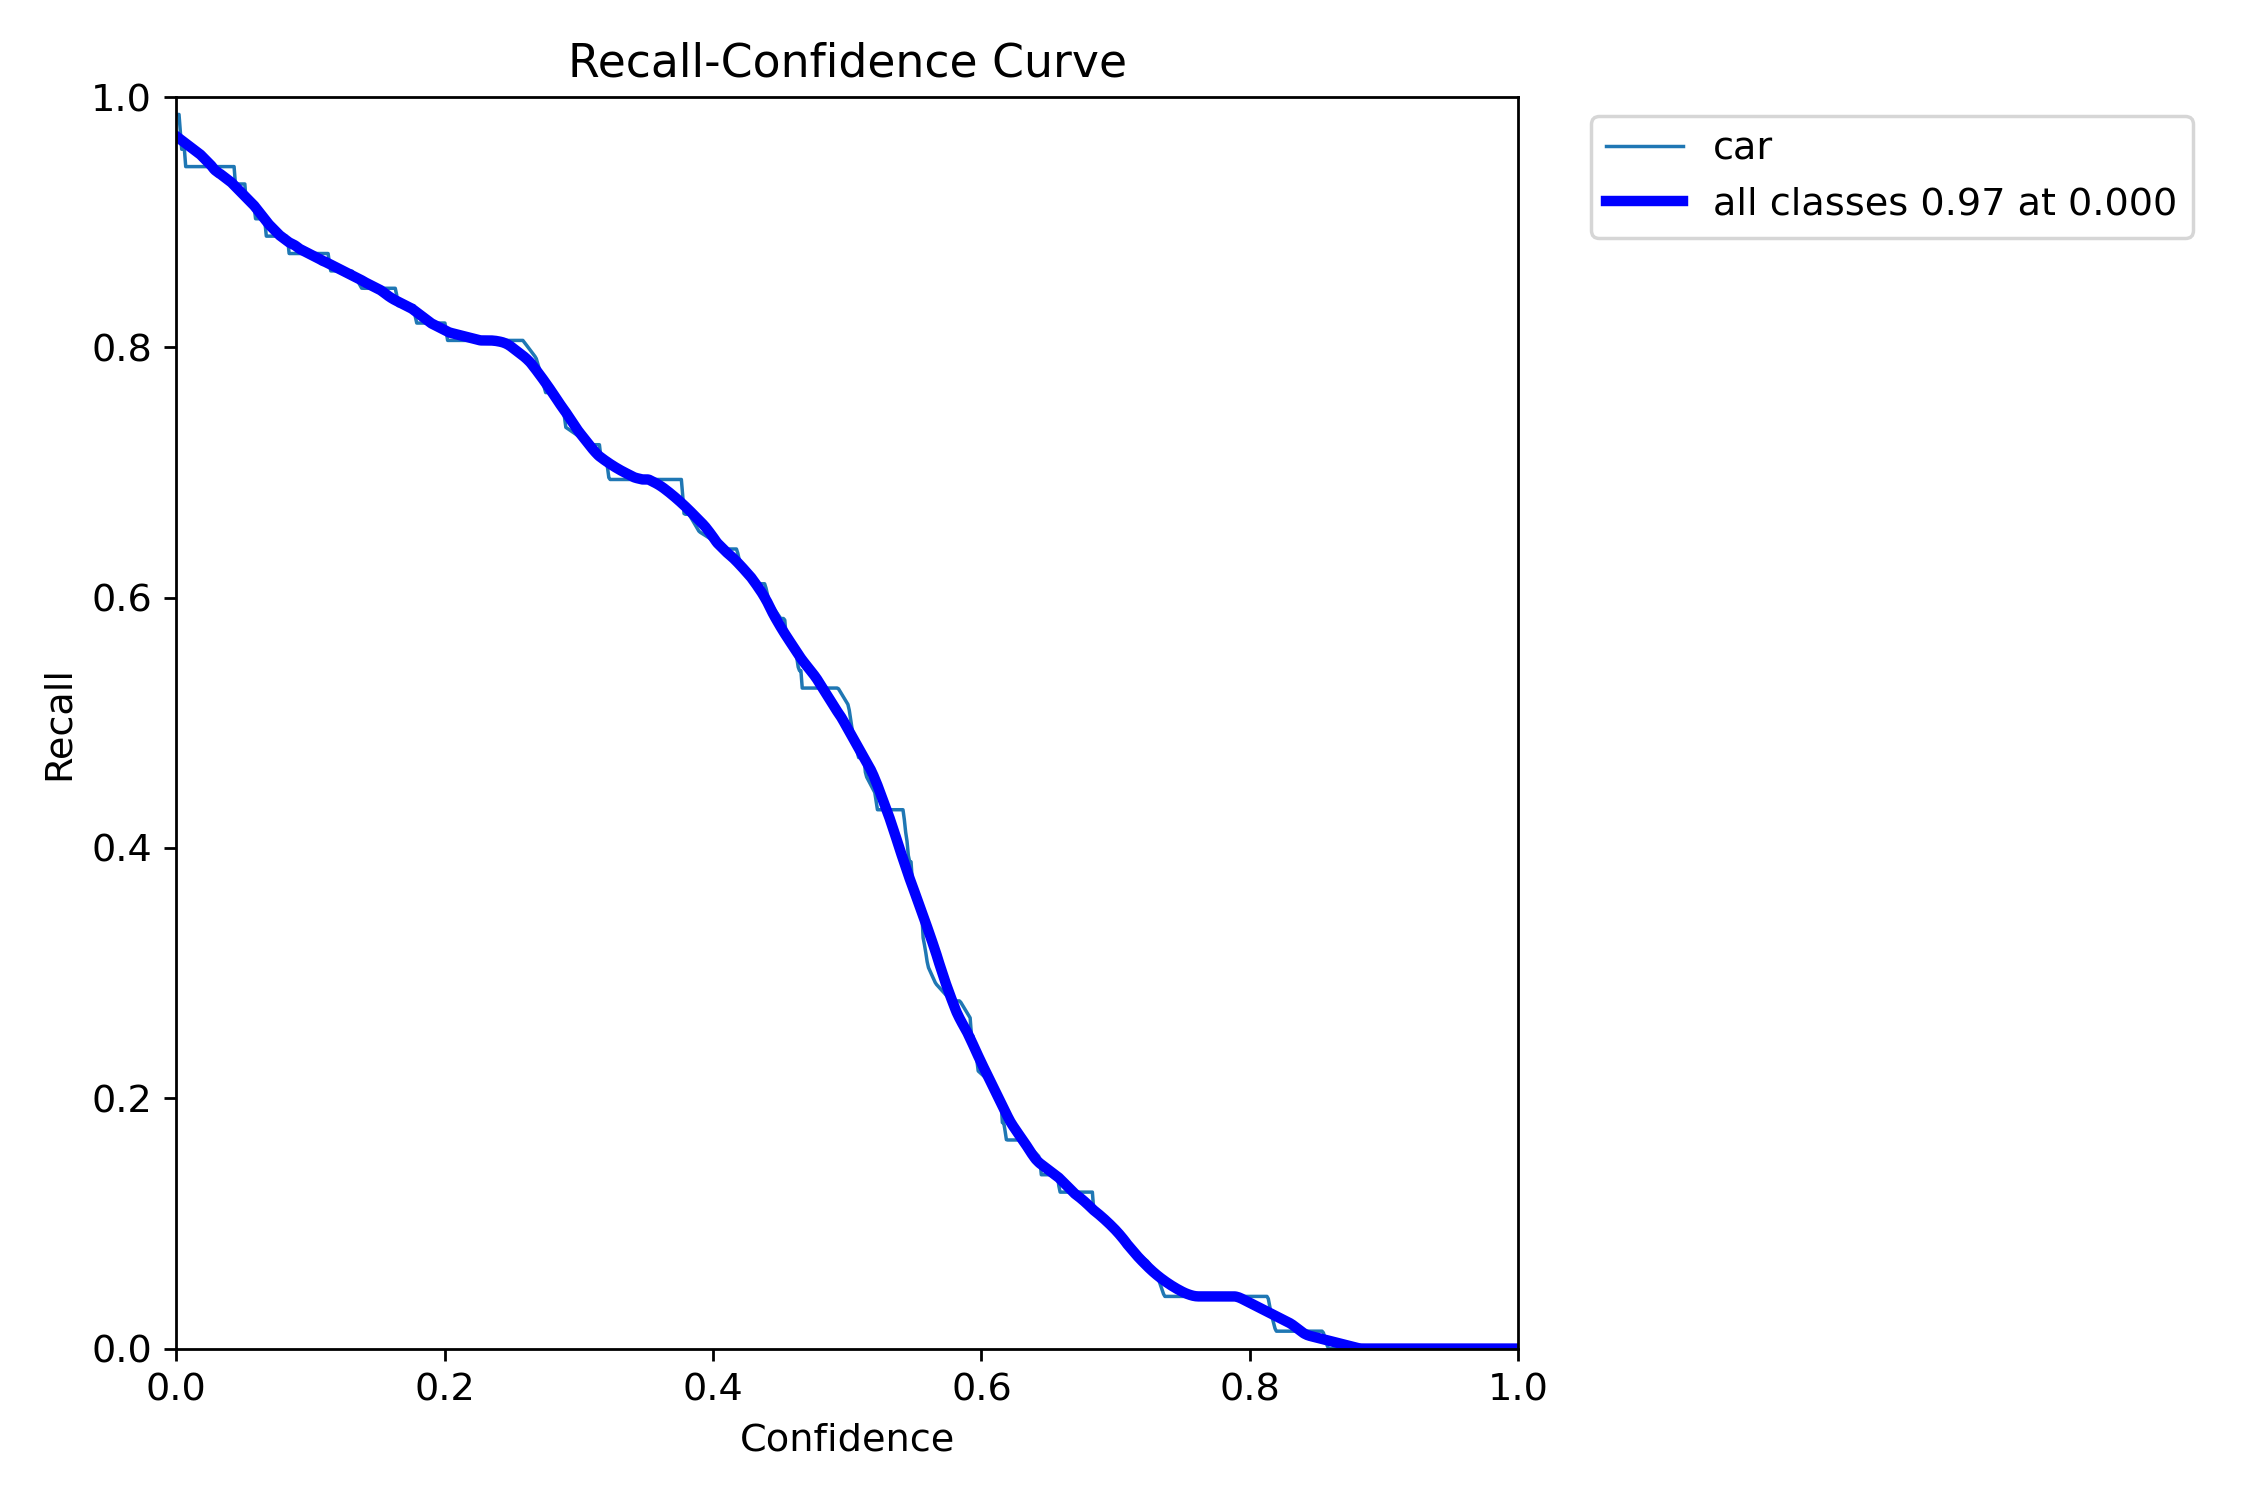

In [29]:
%cd /content
Image(filename=f'/content/runs/detect/train3/R_curve.png', width=600)

/content


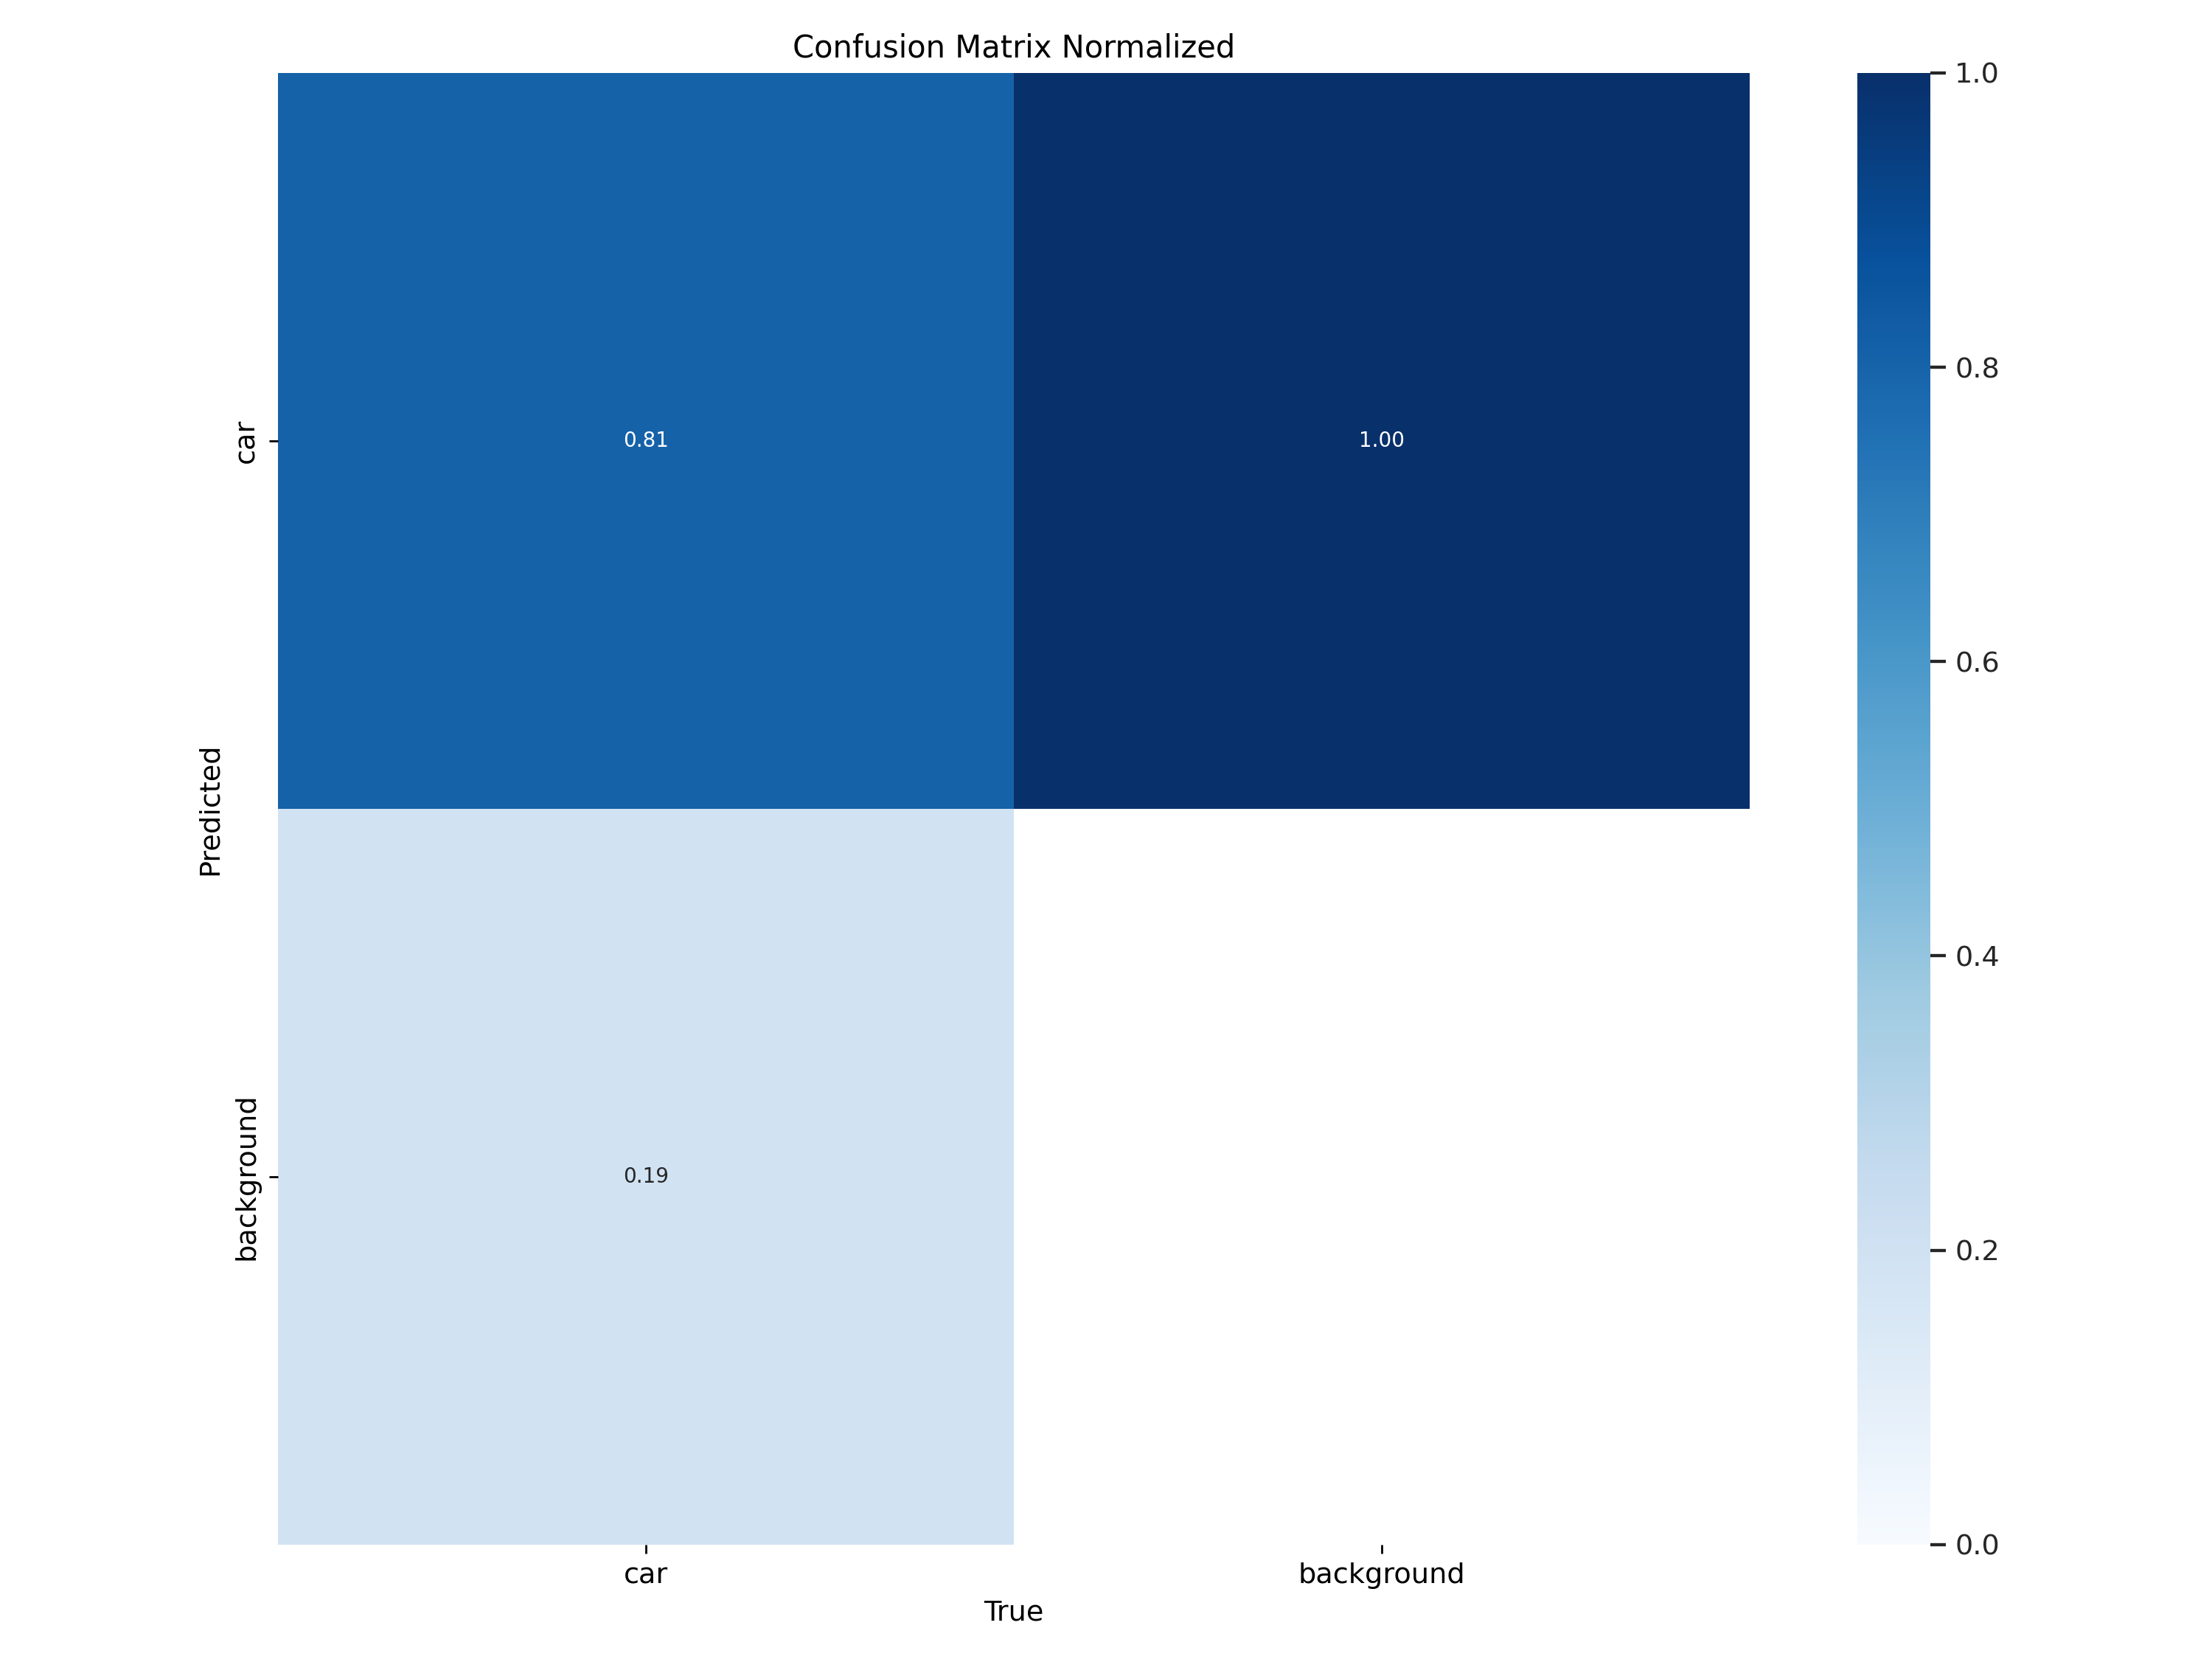

In [30]:
%cd /content
Image(filename=f'/content/runs/detect/train3/confusion_matrix_normalized.png', width=600)

In [31]:
%cd /content

!yolo task=detect mode=val model=/content/runs/detect/train3/weights/best.pt data={dataset_path}/dataset.yaml

/content
Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/drive/MyDrive/assigment/val.cache... 236 images, 164 backgrounds, 0 corrupt: 100% 236/236 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 15/15 [00:08<00:00,  1.77it/s]
                   all        236         72      0.506      0.796      0.532      0.279
Speed: 1.4ms preprocess, 18.9ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/val3
💡 Learn more at https://docs.ultralytics.com/modes/val


In [32]:
%cd /content
!yolo task=detect mode=predict model=/content/runs/detect/train3/weights/best.pt conf=0.25 source={dataset_path}/test save=True

/content
Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/175 /content/drive/MyDrive/assigment/test/vid_5_25100.jpg: 480x800 (no detections), 102.5ms
image 2/175 /content/drive/MyDrive/assigment/test/vid_5_25120.jpg: 480x800 (no detections), 35.9ms
image 3/175 /content/drive/MyDrive/assigment/test/vid_5_25140.jpg: 480x800 (no detections), 35.9ms
image 4/175 /content/drive/MyDrive/assigment/test/vid_5_25160.jpg: 480x800 (no detections), 35.8ms
image 5/175 /content/drive/MyDrive/assigment/test/vid_5_25180.jpg: 480x800 (no detections), 35.8ms
image 6/175 /content/drive/MyDrive/assigment/test/vid_5_25200.jpg: 480x800 (no detections), 27.6ms
image 7/175 /content/drive/MyDrive/assigment/test/vid_5_25220.jpg: 480x800 1 car, 27.5ms
image 8/175 /content/drive/MyDrive/assigment/test/vid_5_25240.jpg: 480x800 (no detections), 27.7ms
image 9/175 /content/drive/MyDrive/assi

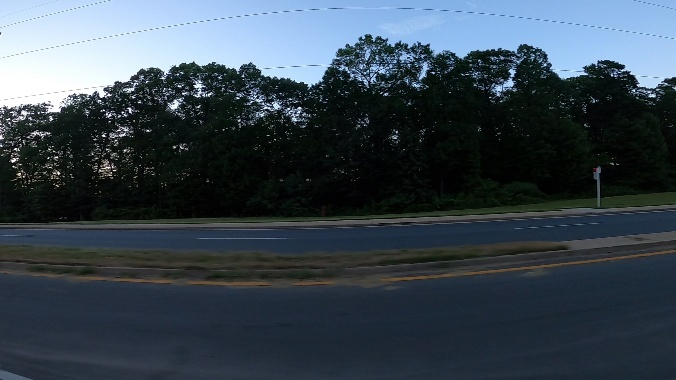

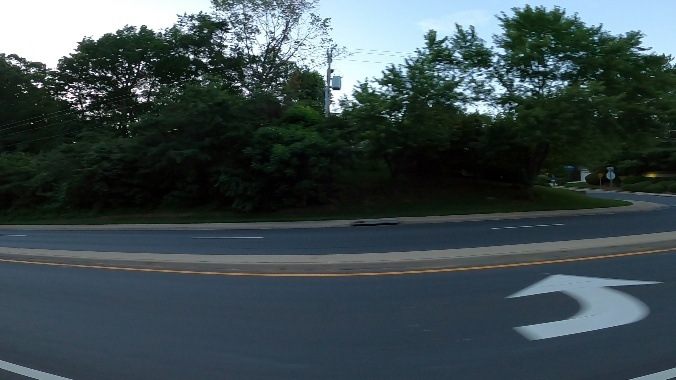

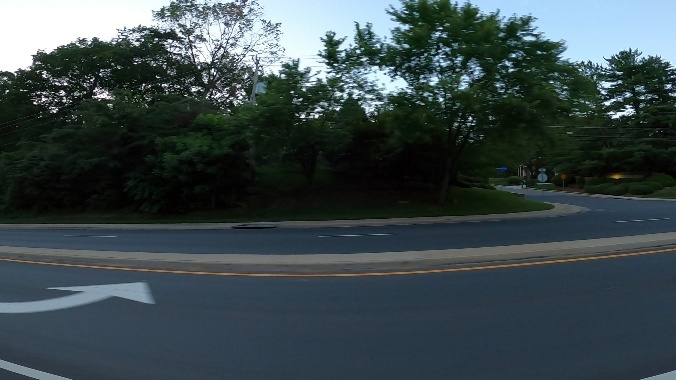

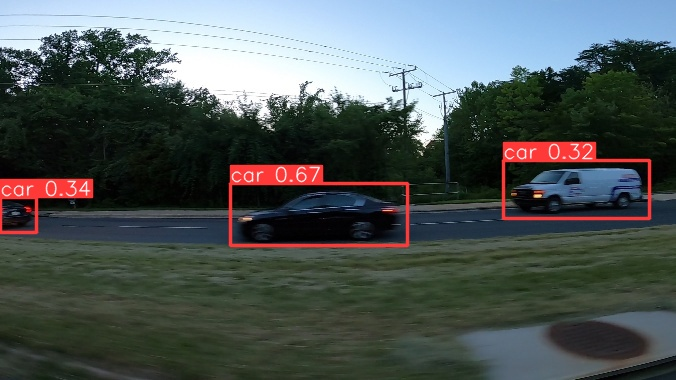

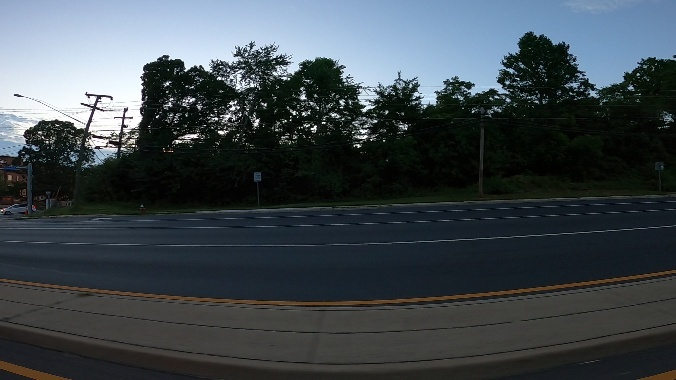

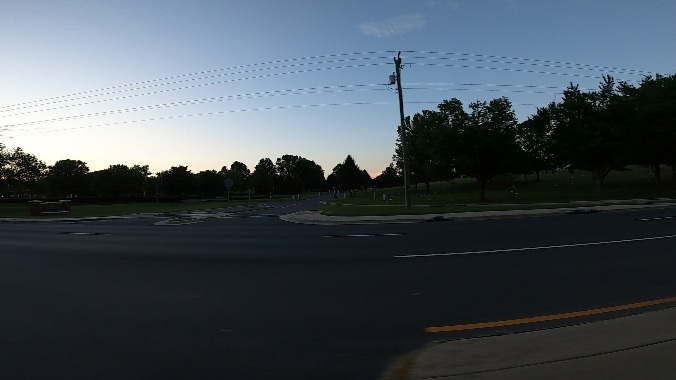

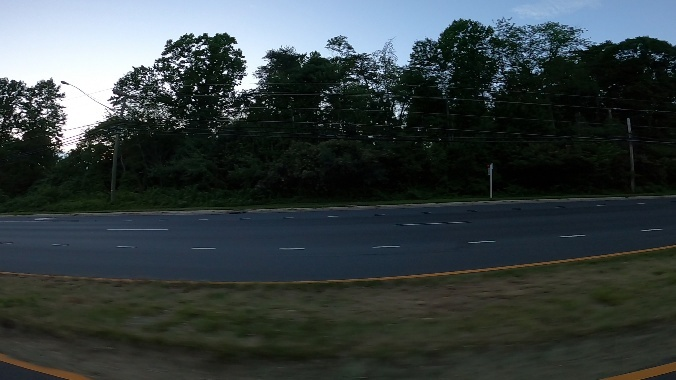

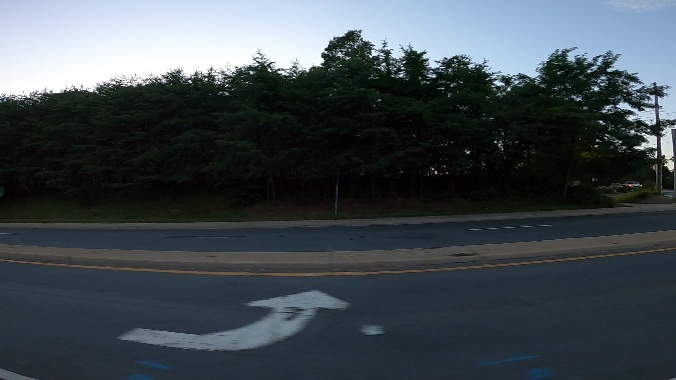

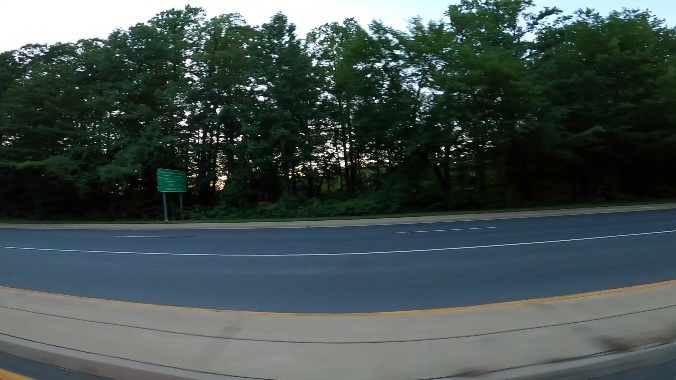

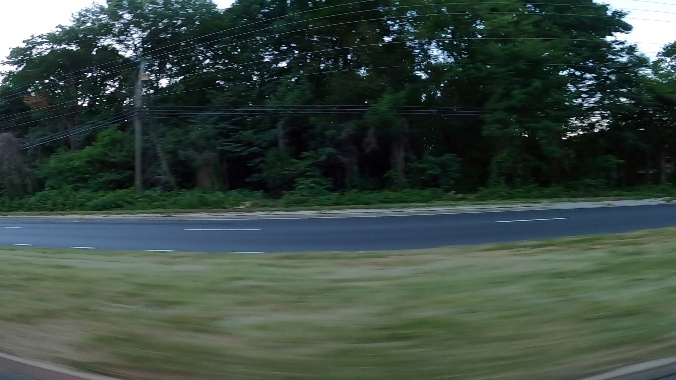

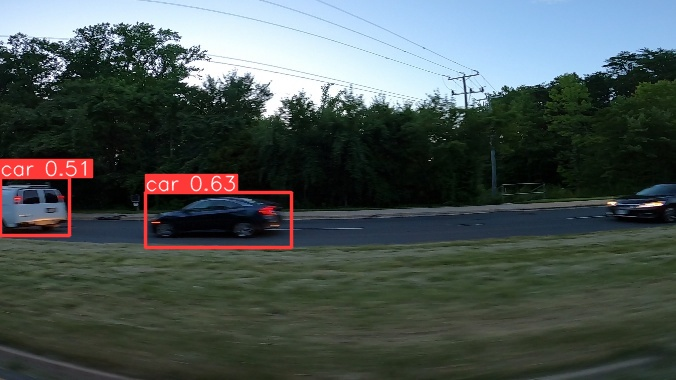

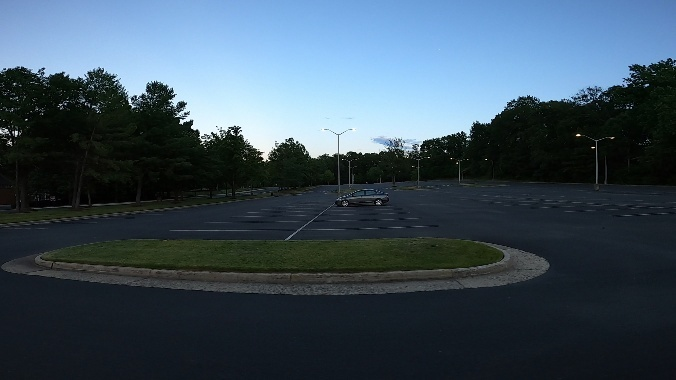

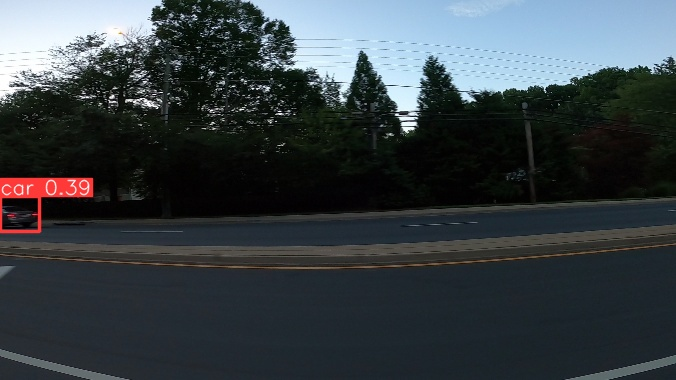

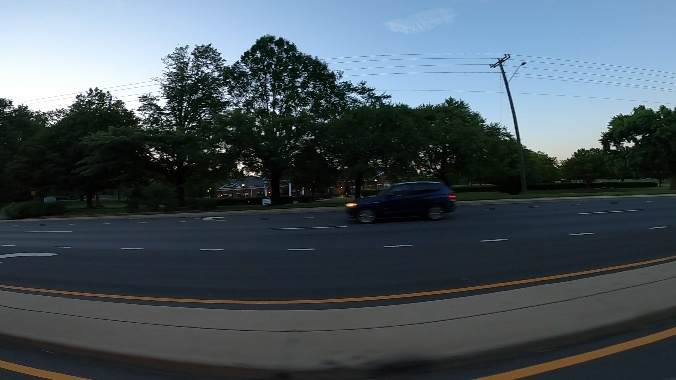

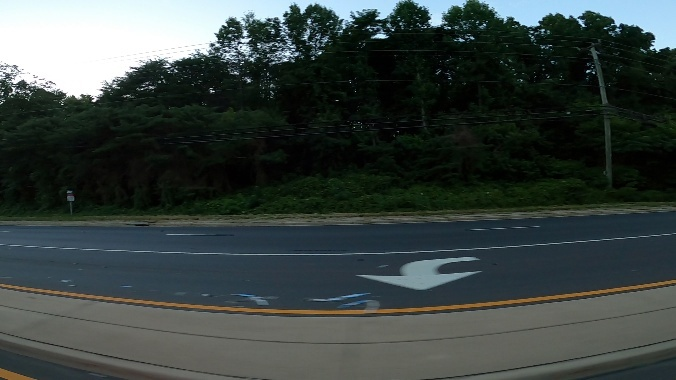

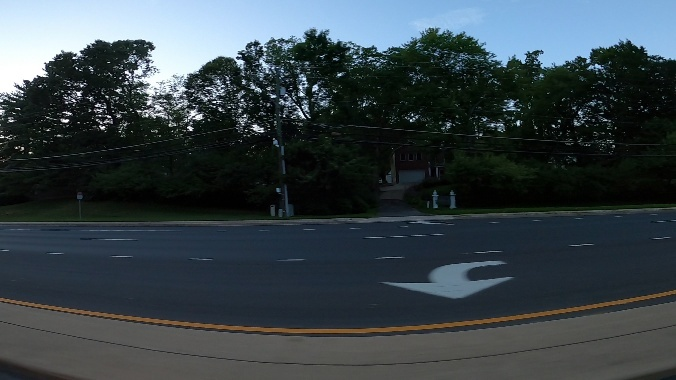

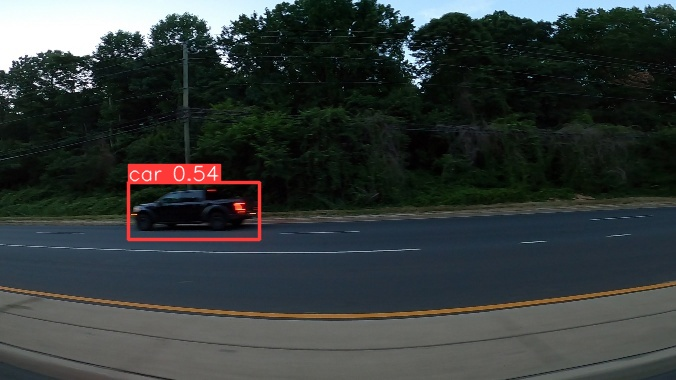

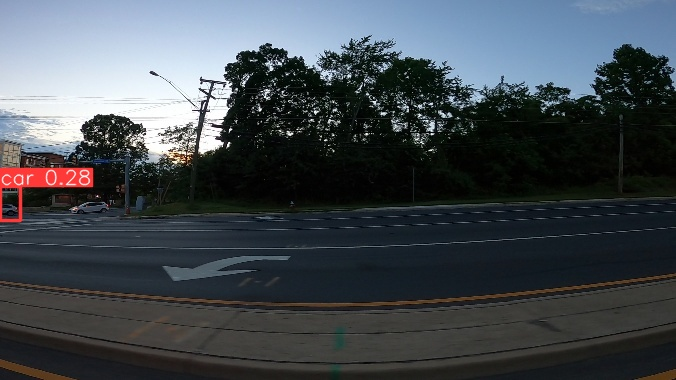

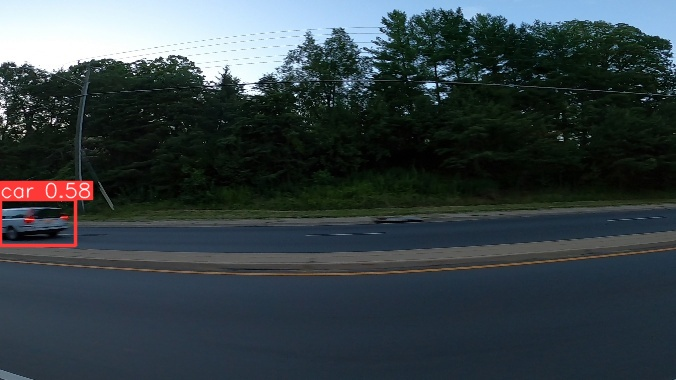

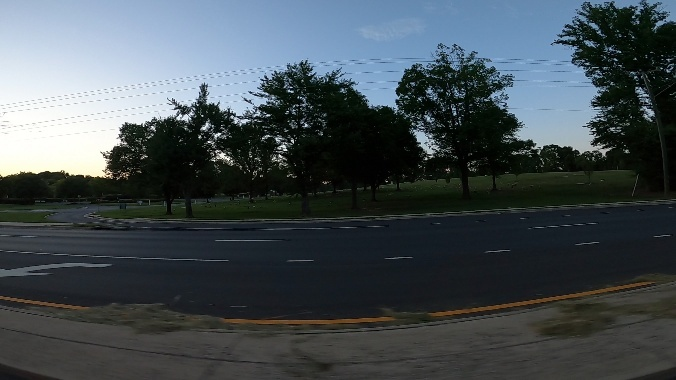

In [33]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/runs/detect/predict3/*.jpg')[:20]:
      display(Image(filename=image_path, width=600))
      print("\n")